# Logistic Regression from Scratch
Last week we used logistic regression to build our first brain signal decoder. Recall that the logistic model takes a measurement and determines the probability that it is associated with a binary outcome. In our case, we found that the degree of match between the EEG waveform and the average evoked response to a stimulus predicted whether a stimulus had been presented. We fit the logistic model using the scikit-learn package, but this masks much of what is going on 'under-the-hood' when it comes to fitting. The best way to learn about this is to code it ourselves, and in the process we will get a few side benefits. 
1. It will introduce us to more theoretical aspects of *optimization*, such as convex functions and gradient descent. These topics are broadly applicable across the machine learning field. 
2. The logistic model itself can be thought of as a single computational unit in a larger neural network, so a deep understanding of how it operates will help demystify more complex neural network models that you cover in other courses. 
3. This knowledge will set us up for adding additional complexity to our logistic decoder. In subsequent lectures we will cover how to use logisitic decoders with multiple inputs, and pool multiple decoders together to decode multiple categories of events.

In [1]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import torch
from torch.utils.data import Dataset, DataLoader

## The problem

We have to find the parameters that best describe the relationship between neural features (ERP magnitude) and the trial class (Cue vs. No Cue). The space of possible parameters is infinite, and we want an approach to find them that is general enough to work with any data set we throw at it. One way is to randomly guess the parameters, and to keep guessing until we get a good fit. Here are some random guesses:


In [2]:
# load data from last week
data_dir = '../Week4/data/'

# load data
X = np.load(os.path.join(data_dir, 'X.npy'))
y = np.load(os.path.join(data_dir, 'y.npy'))

# load fitted parameters
params = json.load(open(os.path.join(data_dir, 'model_params.json'), 'r'))

In [3]:
# get the model parameters fitted by sklearn
w_sk = params['coef']
b_sk = params['intercept']

print('Sklearn model parameters:')
print('w =', w_sk)
print('b =', b_sk)

Sklearn model parameters:
w = 0.05187913417506095
b = -1.8628904500466834


In [4]:
def logistic(x, w, b):
    return 1 / (1 + np.exp(-(w*x + b)))

def plot_logistic(X_vals, y_vals, w, b, ax=None):
    if ax is None:
        fig, ax = plt.subplots()
    ax.scatter(X_vals, y_vals, alpha=0.5)
    x = np.linspace(np.min(X_vals), np.max(X_vals), 100)
    ax.plot(x, logistic(x, w, b), 'r')
    ax.grid()
    return ax

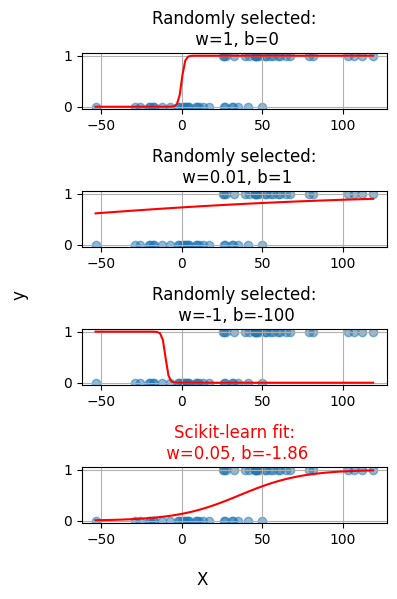

In [5]:
fig, ax = plt.subplots(4,1, figsize=(4,6))

plot_logistic(X, y, 1, 0, ax=ax[0])
ax[0].set_title('Randomly selected:\n w=1, b=0')
plot_logistic(X, y, 0.01, 1, ax=ax[1])
ax[1].set_title('Randomly selected:\n w=0.01, b=1')
plot_logistic(X, y, -1, -10, ax=ax[2])
ax[2].set_title('Randomly selected:\n w=-1, b=-100')
plot_logistic(X, y, params['coef'], params['intercept'], ax=ax[3])
ax[3].set_title('Scikit-learn fit:\n w={:.2f}, b={:.2f}'.format(w_sk, b_sk),color='r')
fig.supxlabel('X')
fig.supylabel('y')
fig.tight_layout()

Those random guesses don't look too good! While it may be tempting to keep trying different combinations of `w` and `b` to get a better fit, that would be a poor use of our time. Moreover, we would have to go through the same process for each new data set.

Instead, perhaps we could start with a random choice, and then iteratively update our parameters to try and get a better fit. At each update, we want to move the parameters so the fit gets better. This process is called *optimization*. For this to work, we need two things: a measure of the fit (referred to as a *loss function*), and a method for minimizing the loss function (we will use *gradient descent*). Let's discuss each of these in turn.

## Loss function
The loss function reflects the difference between the actual class, $y$, and the predicted probability of that class,  $\hat{y}$. The lower value it has, the better the fit. To start building this function, let's consider the probability of $y$ given our prediction, $\hat{y}$, expressed as $p(y|\hat{y})$. Since $y$ is a binary variable (i.e. Cue or NoCue), we can express the probability as a Bernoulli distribution:

$$ p(y|\hat{y}) = \hat{y}^y(1-\hat{y})^{1-y} \tag{1}$$

Note that if $y=1$, we just return $\hat{y}$, because:

$$ \begin{align} 
    \notag p(1|\hat{y}) &= \hat{y}^1(1-\hat{y})^{1-1}  \\
    \notag &= \hat{y}^1(1-\hat{y})^{0} \\ 
    \notag &= \hat{y}^1\times 1 \\
    \notag &= \hat{y}
    \end{align}
$$


and if $y=0$, then $1-\hat{y}$ is returned:
$$ \begin{align} 
    \notag p(0|\hat{y}) &= \hat{y}^0(1-\hat{y})^{1-0}  \\
    \notag &= 1\times(1-\hat{y})^{1} \\ 
    \notag &= 1-\hat{y}
    \end{align}
$$

Alternatively, it might make more sense to you if we express equation 1 as a piecewise function.
$$ p(y|\hat{y})=\begin{cases}
    \hat{y} & y=1 \\
    1-\hat{y} & y=0
    \end{cases}
$$

Each possiblity is represented as a different case enclosed by the large bracket. Here y=1 when a cue occurs, and y=0 when no cue is present. If a cue occured, then we return the probability of the cue, $\hat{y}$. If no cue occured, then we return the probability that no cue occured, $1-\hat{y}$. 

How does equation 1 behave depending on $y$ and $\hat{y}$?

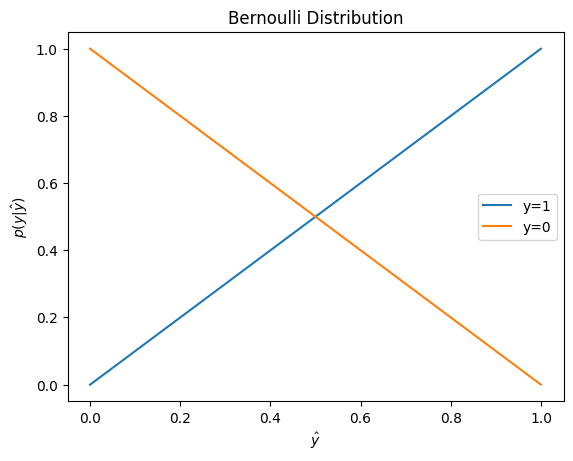

In [6]:
# method for calculating Bernoulli distribution
def bernoulli_dist(y, y_hat):
    return np.power(y_hat, y) * np.power(1-y_hat,1-y)

# array of potential y_hat values, probabilities range from 0 to 1
y_hat = np.linspace(0, 1, 100)

# plot the Bernoulli distribution for y=1 and y=0
fig, ax = plt.subplots()
ax.plot(y_hat, bernoulli_dist(1, y_hat), label='y=1')
ax.plot(y_hat, bernoulli_dist(0, y_hat), label='y=0')
ax.set_xlabel(r'$\hat{y}$')
ax.set_ylabel(r'$p(y|\hat{y})$')
ax.set_title('Bernoulli Distribution')
ax.legend()
plt.show()

Using the Bernoulli distribution, if we fit a model successfully so that it correctly predicts $y$, then trials with a cue ($y=1$) will return high values of $\hat{y}$. Correctly predicting no cue ($y=0$), will give high values as well since $1-\hat{y}$ is returned. Performing this calculation for each pair of predicted and actual values, we can sum those together and evaluate the overall performance of our model. Put another way, a model with good performance will on average give larger values for $p(y|\hat{y})$. We can use this to compare the random model fits above. 

To visualize this, we can add arrows to our logistic regression graph that represent the output of the Bernoulli probability function for each sample.

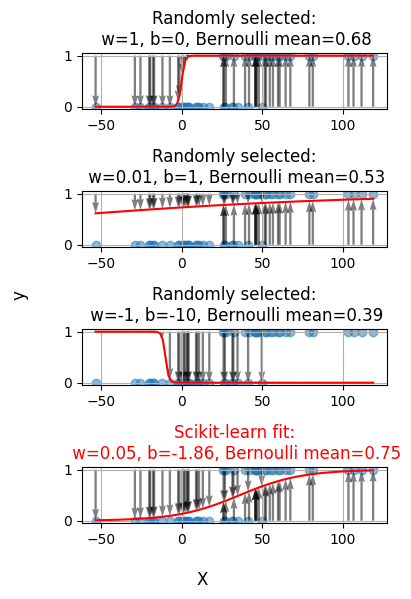

In [7]:
# method to plot the logistic model, 
# corresponding Bernoulli distribution values for each data point, 
# and the mean of the Bernoulli distribution values
def plot_logistic_bern(X_vals, y_vals, w, b, ax=None):
    if ax is None:
        fig, ax = plt.subplots()
    ax = plot_logistic(X_vals, y_vals, w, b, ax=ax)

    sign_y = np.sign(y_vals - 0.5)

    bern_vals = bernoulli_dist(y_vals, logistic(X_vals.squeeze(), w, b))
    ax.quiver(X_vals, 1-y_vals, np.zeros(y_vals.size), 
              sign_y*bern_vals, angles='xy', scale_units='xy', scale=1, alpha=0.5)
    return ax, np.mean(bern_vals)

fig, ax = plt.subplots(4,1, figsize=(4,6))

_, bern_sum = plot_logistic_bern(X, y, 1, 0, ax=ax[0])
ax[0].set_title('Randomly selected:\n w=1, b=0, Bernoulli mean={:.2f}'.format(bern_sum))
_, bern_sum = plot_logistic_bern(X, y, 0.01, 1, ax=ax[1])
ax[1].set_title('Randomly selected:\n w=0.01, b=1, Bernoulli mean={:.2f}'.format(bern_sum))
_, bern_sum = plot_logistic_bern(X, y, -1, -10, ax=ax[2])
ax[2].set_title('Randomly selected:\n w=-1, b=-10, Bernoulli mean={:.2f}'.format(bern_sum))
_, bern_sum = plot_logistic_bern(X, y, params['coef'], params['intercept'], ax=ax[3])
ax[3].set_title('Scikit-learn fit:\n w={:.2f}, b={:.2f}, Bernoulli mean={:.2f}'.format(w_sk, b_sk, bern_sum), color='r')
fig.supxlabel('X')
fig.supylabel('y')
fig.tight_layout()


Each datapoint has a black arrow pointing at it whose length is the Bernoulli distribution value for that particular observation. Longer arrows indicate a better match between the predicted and actual class. The top example has a high mean probability. This is because it has more of its Cue trials on the high probability side, and NoCue trials on the low probability side. The second example is similar, but the logistic function is so broad that the expected probabilities, $\hat{y}$, are never close to 0 or 1. Worst is the third example, whose sign is flipped with peak probability predicted for low x-values that is only summing probabilities for NoCue trials. Lastly, the fitted parameters derived from the scikit-learn logisitic regression object have the highest, and best, mean probability.

The behavior of the Bernoulli probability function makes it a good basis for constructing our loss function. To make it an actual loss function, we will make two changes. First, we will take its logarithm. This has several benefits. For now, we will just note that it changes the shape of the probability curves to give stronger weight to mismatches between the predicted and actual classes. Put another way, wrong answers are penalized more than correct ones. Second, we negate it so that lower values correspond to better fits. This is because the process we use for optimization is *gradient* __*descent*__, which tries to minimize the loss function. Semantically this makes sense, a smaller loss value should correspond to a better fit. So how does our loss function look?

$$ \begin{align}
    \notag -\log(p(y|\hat{y})) &= -\log(\hat{y}^y(1-\hat{y})^{1-y}) \\
    \notag &= -(y\log(\hat{y}) + (1-y)\log(1-\hat{y})) \\
    \end{align}
$$ 
(If you cannot follow the algebra here, see the appendix for rules for working with logarithms)

This loss function is referred to as the cross-entropy loss and is used in many machine learning applications that perform binary classification besides just logistic regression.


/var/folders/xr/cvz2q4cs7mn5n78kvjyvkb_00000gn/T/ipykernel_50874/1054478998.py:3: RuntimeWarning: divide by zero encountered in log
  return -(y*np.log(y_hat) + (1-y)*np.log(1-y_hat))
/var/folders/xr/cvz2q4cs7mn5n78kvjyvkb_00000gn/T/ipykernel_50874/1054478998.py:3: RuntimeWarning: invalid value encountered in multiply
  return -(y*np.log(y_hat) + (1-y)*np.log(1-y_hat))


Text(0.5, 1.05, 'Cross-entropy loss')

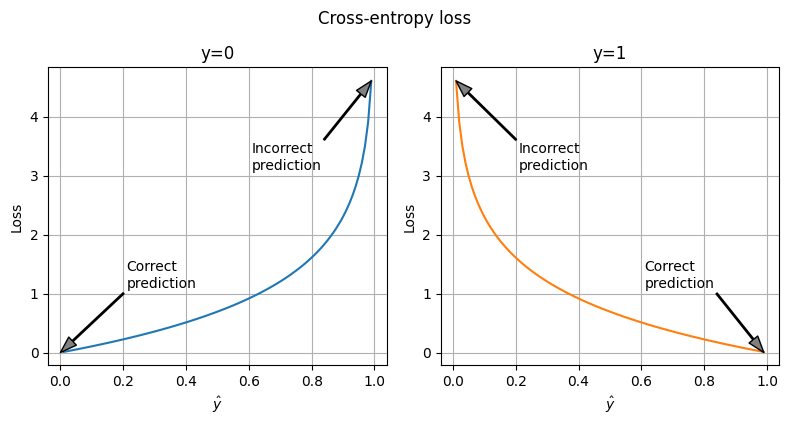

In [8]:
# cross entropy loss function
def cross_entropy(y, y_hat):
    return -(y*np.log(y_hat) + (1-y)*np.log(1-y_hat))


# plot comparison of Bernoulli and cross-entropy loss
# note we start at 0.01 to avoid log(0), which is undefined
x = np.linspace(0.01, 1, 100)

fig, ax = plt.subplots(1,2, figsize=(8,4))
# plot the cross-entropy loss when y=0
ax[0].plot(x, cross_entropy(0, x), color='tab:blue')
ax[0].set_title('y=0')
ax[0].grid()
ax[0].set_xlabel(r'$\hat{y}$')
ax[0].set_ylabel('Loss')
ax[0].annotate('Correct\nprediction', xy=(0, 0), xytext=(0.21, 1.1), 
                arrowprops=dict(facecolor='gray', width=1, headwidth=8))
ax[0].annotate('Incorrect\nprediction', xy=(0.99, cross_entropy(0,0.99)), xytext=(0.61, 3.1), 
                arrowprops=dict(facecolor='gray', width=1, headwidth=8))

# plot the cross-entropy loss when y=1
ax[1].plot(x, cross_entropy(1, x), color='tab:orange')
ax[1].set_title('y=1')
ax[1].grid()
ax[1].set_xlabel(r'$\hat{y}$')
ax[1].set_ylabel('Loss')
ax[1].annotate('Incorrect\nprediction', xy=(0.01, cross_entropy(0,0.99)), xytext=(0.21, 3.1), 
                arrowprops=dict(facecolor='gray', width=1, headwidth=8))
ax[1].annotate('Correct\nprediction', xy=(0.99, 0), xytext=(0.61, 1.1), 
                arrowprops=dict(facecolor='gray', width=1, headwidth=8))

fig.tight_layout()
fig.suptitle('Cross-entropy loss', y=1.05)

Here we can see that the cross-entropy loss function has the desired properties. It is larger the more incorrect our probability is (e.g. $y=0$ has largest loss when $\hat{y}=1$). As the predicted probability approaches the true probability, the loss approaches 0, reaching it when our prediction is correct. This is the case for both types of outcomes, 0 or 1, or in our specific case Cue or NoCue.

The cross-entropy loss function as written above only applies to a single sample. However, when fitting the logistic regression we have to minimize the loss across multiple samples. We can do this by taking the mean of the cross-entropy loss across samples like so:

$$ loss = -\frac{1}{N}\sum_{i=0}^{N}y_{i}\log(\hat{y}_{i}) + (1-y_{i})\log(1-\hat{y}_{i}) \tag{2}$$

Here $i$ refers to a sample and we have $N$ total samples in our data set. Translating this into code we get:

In [9]:
# Version of the cross entropy loss function that explicitly shows the mean calculation
def cross_entropy_loss_verbose(y, y_hat):
    """
    Calculate the cross entropy loss

    Parameters
    ----------
    y : array
        True labels
    y_hat : array
        Predicted probabilities
    
    Returns
    -------
    loss : float
        The mean cross entropy loss
    """
    
    N = y.size
    loss = 0
    for i in range(N):
        loss += -(y[i]*np.log(y_hat[i])+ (1-y[i])*np.log(1-y_hat[i]))

    return loss/N

# Version of the cross entropy loss function that uses numpy mean
def cross_entropy_loss(y, y_hat):
    """
    Calculate the cross entropy loss

    Parameters
    ----------
    y : array
        True labels
    y_hat : array
        Predicted probabilities
    
    Returns
    -------
    loss : float
        The mean cross entropy loss
    """
    
    return np.mean(-(y*np.log(y_hat)+ (1-y)*np.log(1-y_hat)))

Now that we can calculate the loss, we can see what value it takes for each of our guesses for the logistic regression parameters, and for the one returned by scikit-learn.

/var/folders/xr/cvz2q4cs7mn5n78kvjyvkb_00000gn/T/ipykernel_50874/3423839434.py:44: RuntimeWarning: divide by zero encountered in log
  return np.mean(-(y*np.log(y_hat)+ (1-y)*np.log(1-y_hat)))
/var/folders/xr/cvz2q4cs7mn5n78kvjyvkb_00000gn/T/ipykernel_50874/3423839434.py:44: RuntimeWarning: invalid value encountered in multiply
  return np.mean(-(y*np.log(y_hat)+ (1-y)*np.log(1-y_hat)))


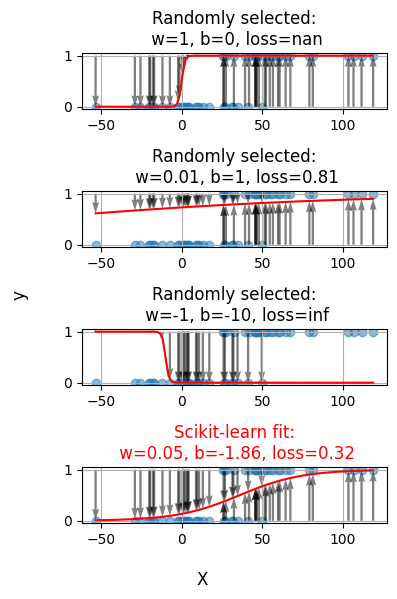

In [10]:
# Plot the cross-entropy loss for each set of model parameters
fig, ax = plt.subplots(4,1, figsize=(4,6))
plot_logistic_bern(X, y, 1, 0, ax=ax[0])
loss = cross_entropy_loss(y, logistic(X.squeeze(), 1, 0))
ax[0].set_title('Randomly selected:\n w=1, b=0, loss={:.2f}'.format(loss))

plot_logistic_bern(X, y, 0.01, 1, ax=ax[1])
loss = cross_entropy_loss(y, logistic(X.squeeze(), 0.01, 1))
ax[1].set_title('Randomly selected:\n w=0.01, b=1, loss={:.2f}'.format(loss))

plot_logistic_bern(X, y, -1, -10, ax=ax[2])
loss = cross_entropy_loss(y, logistic(X.squeeze(), -1, -10))
ax[2].set_title('Randomly selected:\n w=-1, b=-10, loss={:.2f}'.format(loss))

plot_logistic_bern(X, y, params['coef'], params['intercept'], ax=ax[3])
loss = cross_entropy_loss(y, logistic(X.squeeze(), params['coef'], params['intercept']))
ax[3].set_title('Scikit-learn fit:\n w={:.2f}, b={:.2f}, loss={:.2f}'.format(params['coef'], params['intercept'], loss), color='r')
fig.supxlabel('X')
fig.supylabel('y')
fig.tight_layout()

Uh oh, we can already see some problems here. The first and third guesses give a loss of 'nan' and 'inf', respectively. These likely reflect instances where a 0 is passed to `np.log`, which returns -infinity. To address this problem, we can set all instances of `y_hat` equal to 0 to the smallest possible floating point value, and `'y_hat` equal to 1 to its closest value.

In [11]:
# Fixed version of the cross entropy loss function that uses numpy mean
def cross_entropy_loss(y, y_hat):
    """
    Calculate the cross entropy loss

    Parameters
    ----------
    y : array
        True labels
    y_hat : array
        Predicted probabilities
    
    Returns
    -------
    loss : float
        The mean cross entropy loss
    """

    # replace 0s with machine epsilon, the smallest possible floating point number
    y_hat[y_hat==0] = np.finfo(float).eps 

    # replace 1s with 1 minus machine epsilon
    y_hat[y_hat==1] = 1-np.finfo(float).eps 
    
    # calculate the loss
    loss = np.mean(-(y*np.log(y_hat)+ (1-y)*np.log(1-y_hat)))
    
    return loss

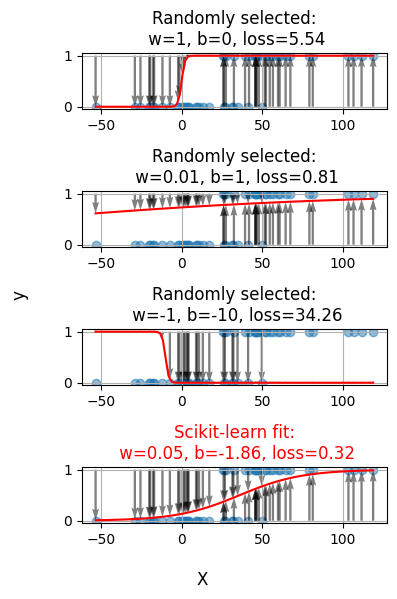

In [12]:
# Plot the fixed version of the cross-entropy loss for each set of parameters
fig, ax = plt.subplots(4,1, figsize=(4,6))
plot_logistic_bern(X, y, 1, 0, ax=ax[0])
loss = cross_entropy_loss(y, logistic(X.squeeze(), 1, 0))
ax[0].set_title('Randomly selected:\n w=1, b=0, loss={:.2f}'.format(loss))

plot_logistic_bern(X, y, 0.01, 1, ax=ax[1])
loss = cross_entropy_loss(y, logistic(X.squeeze(), 0.01, 1))
ax[1].set_title('Randomly selected:\n w=0.01, b=1, loss={:.2f}'.format(loss))

plot_logistic_bern(X, y, -1, -10, ax=ax[2])
loss = cross_entropy_loss(y, logistic(X.squeeze(), -1, -10))
ax[2].set_title('Randomly selected:\n w=-1, b=-10, loss={:.2f}'.format(loss))

plot_logistic_bern(X, y, params['coef'], params['intercept'], ax=ax[3])
loss = cross_entropy_loss(y, logistic(X.squeeze(), params['coef'], params['intercept']))
ax[3].set_title('Scikit-learn fit:\n w={:.2f}, b={:.2f}, loss={:.2f}'.format(params['coef'], params['intercept'], loss), color='r')
fig.supxlabel('X')
fig.supylabel('y')
fig.tight_layout()

Much better! It is not surpising that the cases with the largest loss were the ones previously undefined. They were most likely to have predicted probabilities returned that were closest to 0 or 1 since most datapoints fell on portions of the logisitic equation close to its asymptotes.

To summarize, the cross-entropy loss captures the degree to which the predicted probability of an event agrees with whether that event did or did not occur. Larger values indicate worse predictions, while smaller values suggest better predictions. We calculate this across all samples in our data and return their mean, giving an assessment of the overall performance of our logistic decoder.

## Gradient descent

Now that we have a function that captures the performance of our logistic model, we want to find the combination of $w$ and $b$ parameters that miminize the cross-entropy loss. Scikit-learn offers several different approaches, but all of these are essentially engaging in some form of gradient descent. Indeed, virtually all neural networks are trained via some form of gradient descent procedure. Thus, what we cover here will apply broadly.

To start off, let's consider how gradient descent works with a toy example. Imagine we have a loss function of the form:
$$loss(x) = x^2$$
This is a quadratic function, where $x$ is the parameter that we seek to change to minimize the value of our loss, $x^2$. We can imagine that $loss(x)$ is a surface, so to start exploring that surface we choose a random value of $x$ that will be our starting position.

Starting point: -3.8651152810635048


Text(0.5, 1.0, 'Toy loss function')

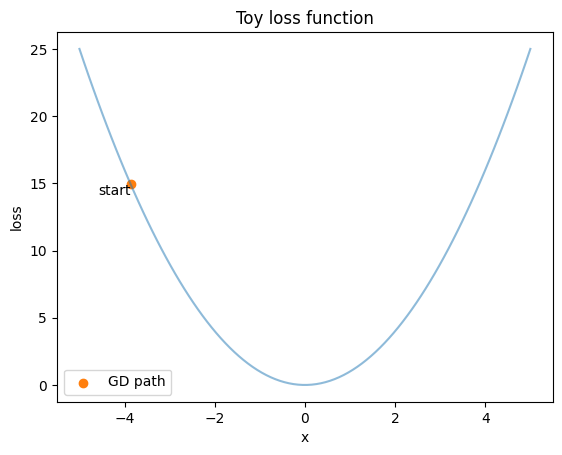

In [13]:
# toy loss function
def toy_loss(x):
    return x**2

# method to plot the landscape of the toy loss function
def plot_loss(ax=None, loss=toy_loss):
    if ax is None:
        fig, ax = plt.subplots()
    x = np.linspace(-5, 5, 100)
    
    loss = loss(x)
    ax.plot(x, loss, color='tab:blue', alpha=0.5)
    ax.set_xlabel('x')
    ax.set_ylabel('loss')
    return ax

# method to plot the path of gradient descent on the toy loss function
def plot_loss_gd(ax=None, loss=toy_loss, x_pts=None):
    if ax is None:
        fig, ax = plt.subplots()
    
    
    if x_pts is not None:
        # plot points using linked arrows, using matplotlib with the start and end points labeled
        ax.quiver(x_pts[:-1], loss(x_pts[:-1]), np.diff(x_pts), np.diff(loss(x_pts)), 
                  angles='xy', scale_units='xy', scale=1, alpha=0.5, color='tab:orange', width=0.005)
        ax.scatter(x_pts, loss(x_pts), color='tab:orange', label='GD path')
        ax.text(x_pts[0], loss(x_pts[0]), 'start', ha='right', va='top')
        if x_pts.size > 1:
            ax.text(x_pts[-1], loss(x_pts[-1]), 'end', ha='left', va='bottom')
        ax.legend()
    
    return ax

# initialize random seed numpy
np.random.seed(47)

# choose our starting point at random
x_hist = np.random.uniform(-5, 5, 1)
print('Starting point:', x_hist[0])
ax = plot_loss()
plot_loss_gd(ax=ax, x_pts=x_hist)
ax.set_title('Toy loss function')

Here the blue line is the loss landscape, a typical quadratic function with a minimum at $x=0$. We have chosen a random start point that is denoted by an orange dot. Our starting point is at $x=-3.86$, which is not at the minimum.

To get closer to the minimum, we can measure the slope of the loss landscape at our starting point, and then move our dot in the direction where that slope is descending. To get that slope, we need the derivative of our loss function, which is $2x$ (solved using the derivative power rule $\frac{d}{dx}x^n=nx^{n-1}$).

Let's code this now:

Text(0.5, 1.0, 'Toy loss function')

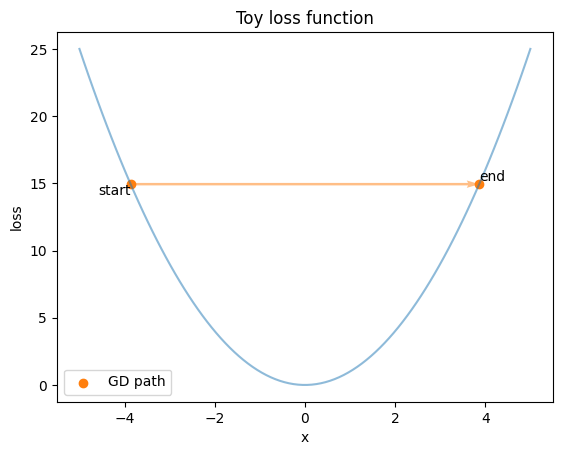

In [14]:
# calculate toy loss derivative
def toy_loss_derivative(x):
    return 2*x

# gradient descent step method
def gd_step(x, d_loss=toy_loss_derivative):
    """
    Perform one step of gradient descent

    Parameters
    ----------
    x : float
        Current value of x
    d_loss : function
        The derivative of the loss function

    Returns
    -------
    x_new : float
        New value of x after one step of gradient descent
    """

    x_new = x - d_loss(x)

    return x_new

# run gradient descent for 1 step
x_hist = np.append(x_hist, gd_step(x_hist[-1]))

ax = plot_loss()
plot_loss_gd(ax=ax, x_pts=x_hist)
ax.set_title('Toy loss function')

Oh no, we moved our dot in the right direction, towards $x=0$, but proceeded to go too far and are now on the other side of the quadratic function. We may want to slow down how fast we are moving our dot so that we minimize the risk of overshooting. For that, we will add an additional argument to our `gd_step` function, `lr`, which stands for *learning rate* (also referred to as eta, $\eta$). The learning rate is a factor (usually much less than 1) that we multiply the gradient by to slow down the speed at which the parameters update. 

Text(0.5, 1.0, 'Toy loss function')

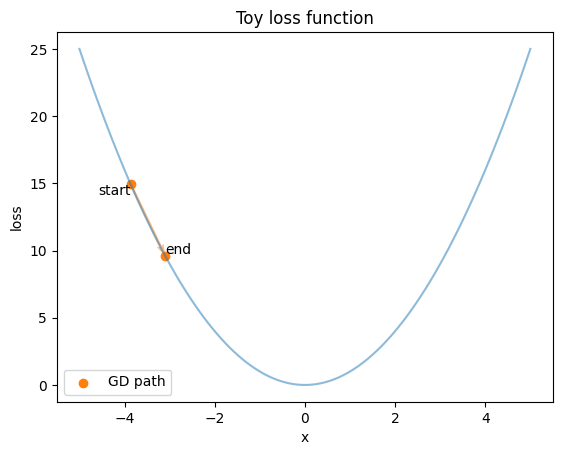

In [15]:
# undo the last, ill-advised step
x_hist = x_hist[:-1]

# gradient descent step method
def gd_step(x, d_loss=toy_loss_derivative, lr=0.1):
    """
    Perform one step of gradient descent

    Parameters
    ----------
    x : float
        Current value of x
    d_loss : function
        The derivative of the loss function
    lr : float
        The learning rate. Default is 0.1

    Returns
    -------
    x_new : float
        New value of x after one step of gradient descent
    """

    x_new = x - lr*d_loss(x)
    
    return x_new

# run gradient descent for 1
x_hist = np.append(x_hist, gd_step(x_hist[-1]))

ax = plot_loss()
plot_loss_gd(ax=ax, x_pts=x_hist)
ax.set_title('Toy loss function')

Much better. We have moved closer to the minimum of our loss function, and without overshooting it. Let's keep going for several more iterations.

Text(0.5, 1.0, 'Toy loss function')

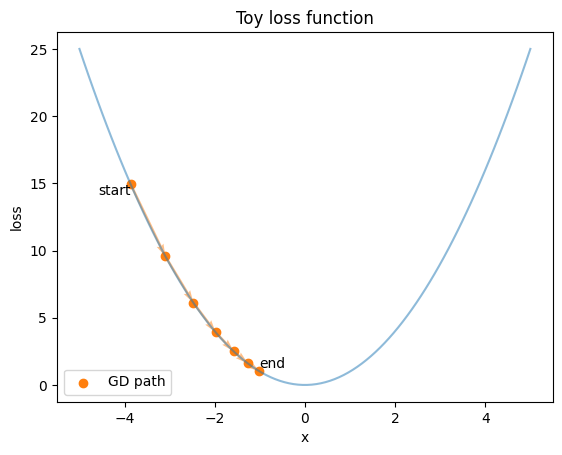

In [16]:
# run gradient descent for 5 more steps
for i in range(5):
    x_hist = np.append(x_hist, gd_step(x_hist[-1]))

ax = plot_loss()
plot_loss_gd(ax=ax, x_pts=x_hist)
ax.set_title('Toy loss function')


After 6 iterations we are closer to the bottom, but still not quite there. Note that the loss changes less and less as we get closer to the minimum.  Instead of trying to guess how many iterations are required, we could keep running the gradient descent process until the changes in the loss falls below a predetermined level, known as a *tolerance*. Here is how we can code that:

In [17]:
# incorporate a stopping criterion into the gradient descent step method
def gd_run(x, d_loss=toy_loss_derivative, lr=0.1, tol=0.01, max_iter=100):
    """
    Perform gradient descent

    Parameters
    ----------
    x : float
        Starting value of x
    d_loss : function
        The derivative of the loss function
    lr : float
        The learning rate. Default is 0.1
    tol : float
        The stopping criterion. Default is 0.01
    max_iter : int
        The maximum number of iterations. Default is 100

    Returns
    -------
    x_hist : array
        History of x values
    i : int
        Number of iterations
    """


    # x is the starting point, so we initialize the history with it
    x_hist = [x]

    # run gradient descent until the stopping criterion is met
    # or until we reach the maximum number of iterations
    for i in range(max_iter):
        # calculate the next step
        x_new = gd_step(x_hist[-1], d_loss=d_loss, lr=lr)
        x_hist.append(x_new)

        # check if the stopping criterion is met
        # if so, break out of the loop
        if np.abs(x_new - x_hist[-2]) < tol:
            break
    
    # return the history of x values and the number of iterations
    x_hist = np.array(x_hist).ravel()
    i = i+1
    return x_hist, i


This method automates our calls to the `gd_step` function. Given a starting point specified by `x`, and a learning rate (`lr`), it will iteratively run `gd_step` until either our loss is below tolerance (`tol`) or maximum number of iterations is reached (`max_iter`).  

Text(0.5, 1.0, 'Toy loss function\nLearning rate = 0.1\nIterations = 21')

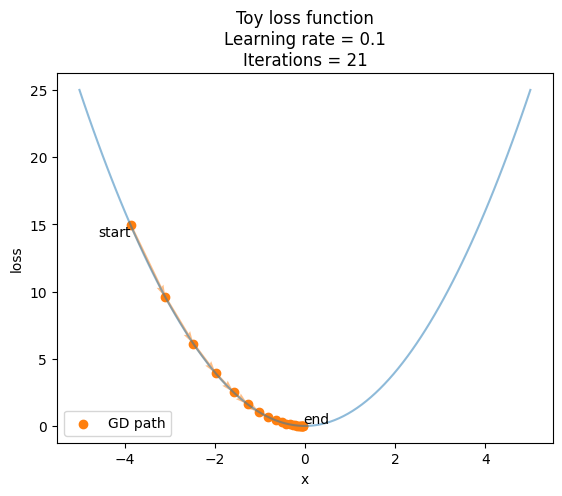

In [18]:
np.random.seed(47)
x_init = np.random.uniform(-5, 5, 1)

# run gradient descent with a learning rate of 0.1
x_hist, n_iter = gd_run(x_init, lr=0.1)

ax = plot_loss()
plot_loss_gd(ax=ax, x_pts=x_hist)
ax.set_title('Toy loss function\nLearning rate = 0.1\nIterations = {}'.format(n_iter))


Just for fun, let's increase the learning rate and see if we can reach the minimum faster.

Text(0.5, 1.0, 'Toy loss function\nLearning rate = 0.8\nIterations = 14')

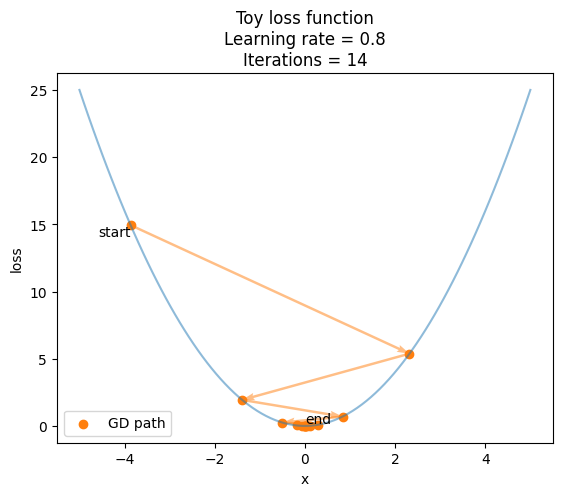

In [19]:
np.random.seed(47)
x_init = np.random.uniform(-5, 5, 1)

# run gradient descent with a learning rate of 0.8
x_hist, n_iter = gd_run(x_init, lr=0.8)

ax = plot_loss()
plot_loss_gd(ax=ax, x_pts=x_hist)
ax.set_title('Toy loss function\nLearning rate = 0.8\nIterations = {}'.format(n_iter))

Notice how increasing the learning rate decreased the number of iterations it took to reach the minimum, but at the cost of causing our path towards that minimum to oscillate. This underscores the importance of *hyperparameters*, such as learning rate, when using machine learning approaches. These often have dramatic impacts whether we are successful in training a decoder.

When would gradient descent fail? Gradient descent will find the minimum loss if the landscape is *convex*. A simple geometric intuition for whether a curve is convex is if you can draw a line between any two points on it, no points on the curve exceed that line.

![Convexity](./images/Convex.png)

In the diagram above, the non-convex curve has a bump in the middle that prevents us from drawing a line between $a$ and $b$ that is not exceeded by the curve (red shaded region). This is commonly expressed mathematically as Jensen's inequality:
$$ f\left(\frac{a+b}{2}\right)\le\frac{f(a)+f(b)}{2} $$

When a function is non-convex, gradient descent can fail. It may get trapped on its path to the minimum value of the function, known as the global minimum. These points where it gets trapped are known as local minima. We can see all of this was a new toy model. In this case, we will use the quadratic function $ y=0.2x^4 -4x^2 - x$.

Starting point: -3.8651152810635048


Text(0.5, 1.0, 'Non-convex toy loss function\nLearning rate = 0.1\nIterations = 7')

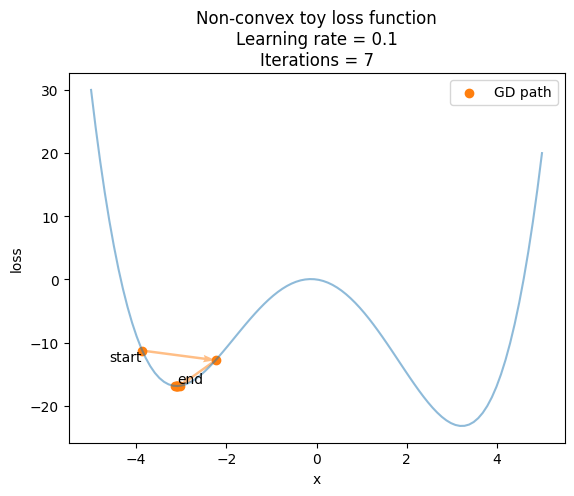

In [20]:
# a non-convex toy loss function
def nc_toy_loss(x):
    return 0.2*x**4 - 4*x**2 - x

# the derivative of the non-convex toy loss function
def nc_toy_loss_derivative(x):
    return 0.8*x**3 - 8*x - 1

# initialize random seed numpy
np.random.seed(47)

# choose our starting point at random
x_hist = np.random.uniform(-5, 5, 1)
print('Starting point:', x_hist[0])
x_hist, n_iter = gd_run(x_init, d_loss=nc_toy_loss_derivative, lr=0.1)

ax = plot_loss(loss=nc_toy_loss)
plot_loss_gd(ax=ax, loss=nc_toy_loss, x_pts=x_hist)
ax.set_title('Non-convex toy loss function\nLearning rate = 0.1\nIterations = {}'.format(n_iter))

If we start our fitting with a negative value of `x`, we get stuck in a valley that is at a higher level than the global minimum. This demonstrates how valuable it is to know whether your loss function is convex. If it is convex, then gradient descent will find the global minimum if run for long enough. 

## Gradient descent for the logistic function

Now that we have defined the loss of the logistic function (eq. 2), and the gradient descent process that optimizes over it to find the best combination of parameters, we can write our own function from scratch to fit a logistic model! But before we do that, let's get a little bit more intuition about how the loss landscape for the logistic model behaves.

First, note that the loss function function is the mean loss across all samples in our data set. How does the number of samples influence the loss landscape? We have two parameters we are varying to fit the logistic function, `b` and `w`, so we can plot the loss landscape as an image plot. Our x and y-axes will be the parameters `b` and `w`, respectively, while the color at each point indicates the loss.

Text(0.5, 1.05, 'Cross-entropy loss landscape varies with number of samples')

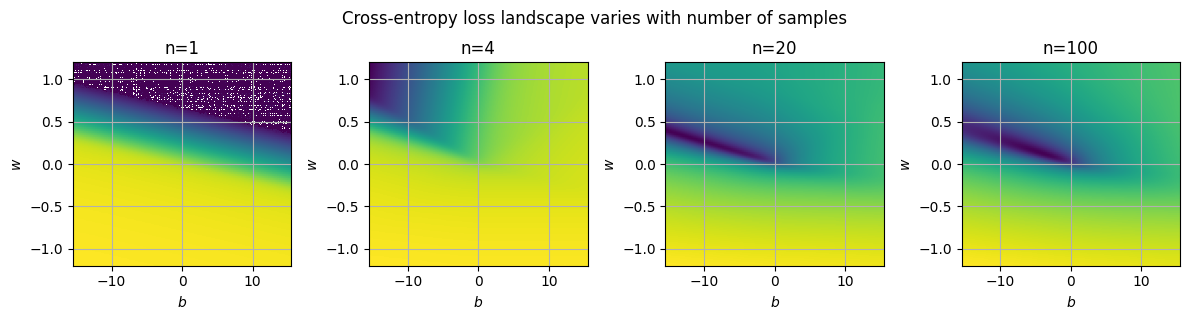

In [21]:
# a function that plots the loss landscape for the logistic model on our data
def plot_logistic_loss_landscape(ax=None, sel_data=None, loss=cross_entropy_loss):
    # Parameters
    # ----------
    # ax : matplotlib axis object, optional
    #     Axis to plot on. If not provided, a new figure and axis will be created.
    # sel_data : array-like, optional
    #     Indices of the data points to use for plotting the loss landscape. If not provided,
    #     all data points will be used.
    # loss : function, optional
    #     Loss function to use. If not provided, cross-entropy loss will be used.
    # Returns
    # -------
    # ax : matplotlib axis object
    #     Axis with the loss landscape plotted.
    # loss_grid : numpy array
    #     Array of loss values for each combination of w and b values.

    if ax is None:
        fig, ax = plt.subplots()
    
    if sel_data is None:
        sel_data = np.arange(0, X.size)
    
    # create a grid of w and b values
    w_grid = np.linspace(-1.2, 1.2, 100)
    b_grid = np.linspace(-15.5, 15.5, 100)
    loss_grid = np.zeros((w_grid.size, b_grid.size))

    # calculate the loss for each combination of w and b values
    for i, w in enumerate(w_grid):
        for j, b in enumerate(b_grid):
            loss_grid[i,j] = loss(y[sel_data], logistic(X.squeeze()[sel_data], w, b))

    # plot the loss landscape
    im = ax.imshow(loss_grid, extent=[b_grid[0], b_grid[-1], w_grid[0], w_grid[-1]],
               norm=colors.LogNorm(), aspect='auto', origin='lower')
    ax.set_xlabel('$b$')
    ax.set_ylabel('$w$')
    ax.grid()
    return ax, loss_grid

# randomize the order of the samples, since the data is ordered
np.random.seed(42)
sel_data = np.random.choice(np.arange(0, X.size), size=X.size, replace=False)

# plot the loss landscape for the logistic model on our data
# using different numbers of samples
fig, ax = plt.subplots(1,4, figsize=(12,3))
for ind, count in enumerate([1, 4, 20, x.size]):
    _, loss_ce = plot_logistic_loss_landscape(ax=ax[ind], sel_data=sel_data[:count])
    ax[ind].set_title('n={}'.format(count))
fig.tight_layout()
fig.suptitle('Cross-entropy loss landscape varies with number of samples', y=1.05)

If we only specify one data point, then the loss landscape is a relatively simple surface that slopes down towards lower values (dark blue) as either `w` or `b` are increased. This is because only one of the samples has to be fit, so as long as the orientation and decision point of our logistic function is set to classify that one data point correctly, our fit will be perfect. When four samples are included, we now have a mixture of trial types, so the logistic model is constrained, we cannot push `w` or `b` towards infinity and still expect perfect performance. A zone starts to emerge with loss minimal for larger values of `w` and negative values of `b`. Further increasing the number of samples creates a well defined valley where loss is minimal.

We chose the cross entropy loss above because of its beneficial properties when working with the Bernoulli probability distribution. However, what if we had gone with another popular loss function, the *mean squared error* (MSE). MSE is the mean difference between our predicted and actual results squared. It is expressed mathematically as:

$$ MSE(y,\hat{y}) = \frac{1}{N}\sum_{i}^{N}(y-\hat{y})^2 $$

This error function is often used when fitting linear systems of equations. If we tried to to use it with our logistic model, what would its loss landscape look like?

Text(0.5, 1.05, 'Mean squared error loss landscape varies with number of samples')

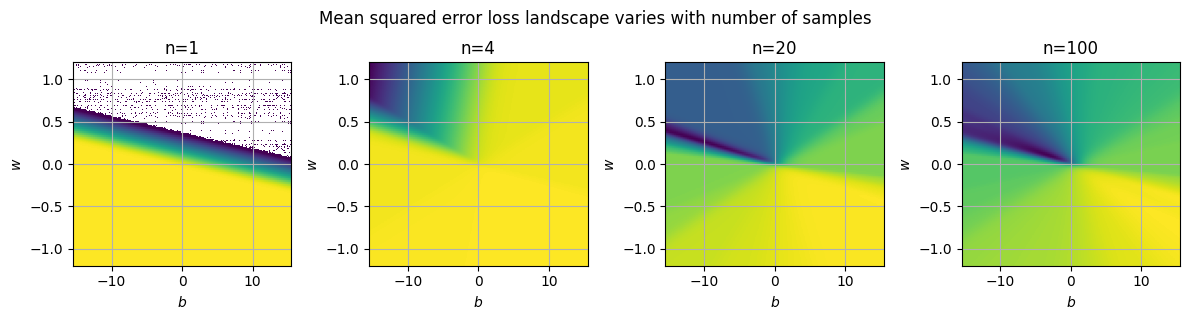

In [22]:
# function for calculating mean squared error loss
def mse_loss(y, y_hat):
    """
    Calculate the mean squared error loss

    Parameters
    ----------
    y : array
        True labels
    y_hat : array
        Predicted probabilities

    Returns
    -------
    loss : float
        The mean squared error loss
    """

    loss = np.mean((y-y_hat)**2)
    
    return loss

# plot the loss landscape for the logistic model on our data
# using different numbers of samples and the mean squared error loss
fig, ax = plt.subplots(1,4, figsize=(12,3))
for ind, count in enumerate([1, 4, 20, x.size]):
    _, loss_mse = plot_logistic_loss_landscape(ax=ax[ind], sel_data=sel_data[:count], loss=mse_loss)
    ax[ind].set_title('n={}'.format(count))
fig.tight_layout()
fig.suptitle('Mean squared error loss landscape varies with number of samples', y=1.05)

While the landscapes look broadly similar, there are important differences. Note that as the number of samples increases, the landscape has a faceted appearance, with straight lines running through it. These correspond to edges in the landscape that make it non-convex. This is best visualized by taking a slice of the landscape and comparing it with the same slice from one generated using the cross-entropy loss.

Text(0.5, 1.0, 'Losses along $b=3.1$')

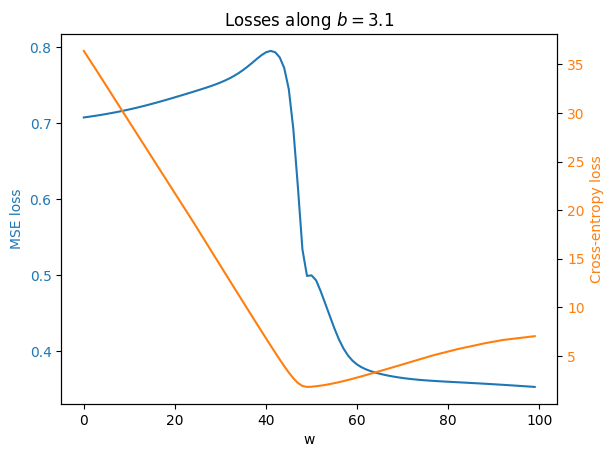

In [23]:
fig, ax = plt.subplots()
ax.plot(loss_mse[:,60])
ax_ce = ax.twinx()
ax_ce.plot(loss_ce[:,60], color='tab:orange')
ax.set_xlabel('w')
ax.set_ylabel('MSE loss', color='tab:blue')
ax.tick_params(axis='y', labelcolor='tab:blue')

ax_ce.tick_params(axis='y', labelcolor='tab:orange')

ax_ce.set_ylabel('Cross-entropy loss', color='tab:orange')
ax.set_title('Losses along $b=3.1$')

Notice how the cross-entropy loss we use for fitting the logistic model is convex, while the mean squared error loss function is not. This means that gradient descent will work with the cross-entropy loss for a logistic model, but it would not work with the mean squared error loss. 

The reason behind this is that the logistic function on its own is non-convex. This can be demonstrated simply by plotting the default logistic function, $\frac{1}{1+e^{-x}}$, and then drawing a line between x=-5 and 5, the logistic function crosses it.

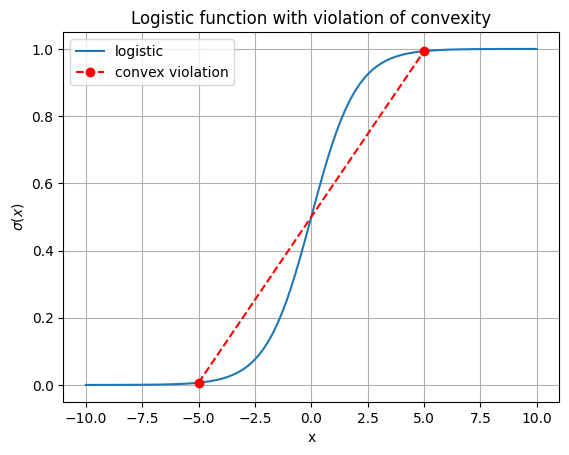

In [24]:
# plot the logistic function
fig, ax = plt.subplots()
x = np.linspace(-10, 10, 100)
ax.plot(x, logistic(x, 1, 0), label='logistic')
ax.set_xlabel('x')
ax.set_ylabel(r'$\sigma(x)$')
ax.grid()

# draw a line between the points on the curve at x = -5 and 5
ax.plot([-5, 5], [logistic(-5, 1, 0), logistic(5, 1, 0)], 'r--', marker='o', label='convex violation')

ax.set_title('Logistic function with violation of convexity')
ax.legend()

What if we passed the logistic function through the cross-entropy loss function? Assuming that the predicted value, $\hat{y}$, is 1, we get:

$$ \begin{align}
    \notag loss &= -ln(\frac{1}{1+e^{-x}})\\
    \notag &= -ln(1) + ln(1+e^{-x})\\
    \end{align}
$$

We can imagine that as $x \to \infty$ the term $e^{-x}$ approaches 0, heading towards $-ln(1)+ln(1)=0$. And, as $x \to -\infty$ the term $ln(1+e^{-x})$ becomes a straight line, since the $1+$ becomes negligble and $ln(e^{-x})=-x$. Let's do some plotting to confirm these intuitions.

(-2.5, 10.0)

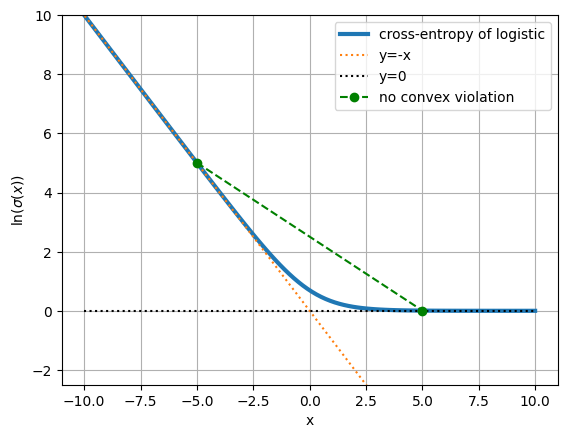

In [25]:
# plot the cross-entropy of the logistic function
fig, ax = plt.subplots()
x = np.linspace(-10, 10, 100)
ax.plot(x, -np.log(logistic(x, 1, 0)), label='cross-entropy of logistic', linewidth=3)
ax.set_xlabel('x')
ax.set_ylabel(r'$\ln(\sigma(x))$')
ax.grid()

# draw a black dotted line for y=-x
ax.plot([10, -10], [-10, 10], ':', label='y=-x', color='tab:orange')

# draw a black dotted line for y=0
ax.plot([-10, 10], [0, 0], 'k:', label='y=0')

# draw a line on the curve between the points -5 and 5
ax.plot([-5, 5], [-np.log(logistic(-5, 1, 0)), -np.log(logistic(5, 1, 0))], 'g--', marker='o', label='no convex violation')

ax.legend()
ax.set_ylim([-2.5, 10])

It is readily apparent that the logistic function when passed through the cross-entropy function is made convex. But recall that the cross-entropy is the average response of our logistic function across all samples. What happens when we add many of these curves together? Fortunately, the addition of any two convex functions results in a new function that is also convex!

Now lets see what happens when we apply the mean squared error loss to the logistic function.

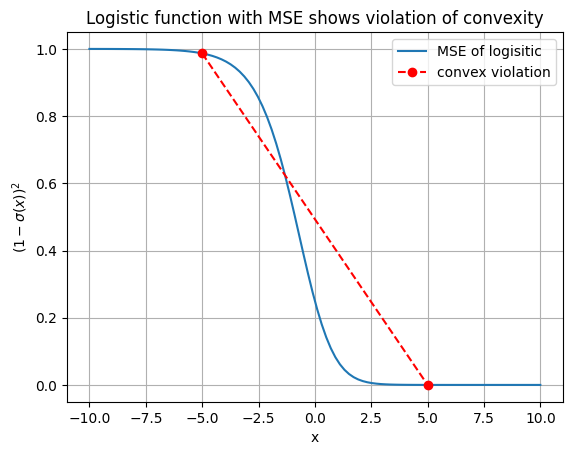

In [26]:
# plot the mean squared error of the logistic function
fig, ax = plt.subplots()
x = np.linspace(-10, 10, 100)
ax.plot(x, np.power(1-logistic(x, 1, 0),2), label='MSE of logisitic')
ax.set_xlabel('x')
ax.set_ylabel(r'$(1-\sigma(x))^2$')
ax.grid()

# draw a line between the points on the curve at x = -5 and 5
ax.plot([-5, 5], np.power(1-np.array([logistic(-5, 1, 0), logistic(5, 1, 0)]),2), 'r--', marker='o', label='convex violation')

ax.set_title('Logistic function with MSE shows violation of convexity')
ax.legend()

The mean squared error does not transform the logistic function in such a manner as to remove the convexity.

Moving on, to run gradient descent, we need to know the derivative of the cross-entropy loss function for the logistic model (eq. 2). For the logistic model, we have to calculate the derivative for our two parameters, $b$ and $w$. We can grind through the math to get these.

The derivative with respect to $w$ is:
$$ \begin{align}
    \notag \frac{\partial{L}}{\partial{w}}&=\frac{\partial}{\partial{w}}-(y\log(\sigma(wx+b))+(1-y)\log(1-\sigma(wx+b)))\\
    \notag &=-\left(\left(\frac{y}{\sigma(wx+b)}\frac{\partial}{\partial{w}}\sigma(wx+b)\right)+\left(\frac{1-y}{1-\sigma(wx+b)}\frac{\partial}{\partial{w}}1-\sigma(wx+b)\right)\right) \\
    \notag &=-\left(\left(\frac{y}{\sigma(wx+b)}\frac{\partial}{\partial{w}}\sigma(wx+b)\right)+\left(\frac{1-y}{1-\sigma(wx+b)}\frac{\partial}{\partial{w}}-\sigma(wx+b)\right)\right) \\
    \notag &=-\left(\frac{y}{\sigma(wx+b)}-\frac{1-y}{1-\sigma(wx+b)}\right)\frac{\partial}{\partial{w}}\sigma(wx+b) \\
    \notag &=-\left(\frac{y(1-\sigma(wx+b))}{\sigma(wx+b)(1-\sigma(wx+b))}-\frac{(1-y)\sigma(wx+b)}{\sigma(wx+b)(1-\sigma(wx+b))}\right)\frac{\partial}{\partial{w}}\sigma(wx+b) \\
    \notag &=-\left(\frac{y-y\sigma(wx+b)}{\sigma(wx+b)(1-\sigma(wx+b))}-\frac{\sigma(wx+b)-y\sigma(wx+b)}{\sigma(wx+b)(1-\sigma(wx+b))}\right)\frac{\partial}{\partial{w}}\sigma(wx+b) \\
    \notag &=-\left(\frac{y-\sigma(wx+b)}{\sigma(wx+b)(1-\sigma(wx+b))}\right)\frac{\partial}{\partial{w}}\sigma(wx+b) \\
    \notag &=-\left(\frac{y-\sigma(wx+b)}{\sigma(wx+b)(1-\sigma(wx+b))}\right)\sigma(wx+b)(1-\sigma(wx+b))\frac{\partial}{\partial{w}}(wx+b) \\
    \notag &=-\left(\frac{y-\sigma(wx+b)}{\sigma(wx+b)(1-\sigma(wx+b))}\right)\sigma(wx+b)(1-\sigma(wx+b))x \\
    \notag &=-(y-\sigma(wx+b))x \\
    \notag &= (\sigma(wx+b)-y)x \\
\end{align}
$$

And the derivative with respect to $b$ is:
$$ \begin{align}
    \notag \textcolor{lightgray}{\frac{\partial{L}}{\partial{b}}}&\textcolor{lightgray}{=\frac{\partial}{\partial{b}}-(y\log(\sigma(wx+b))+(1-y)\log(1-\sigma(wx+b)))}\\
    \notag &\textcolor{lightgray}{=-\left(\left(\frac{y}{\sigma(wx+b)}\frac{\partial}{\partial{b}}\sigma(wx+b)\right)+\left(\frac{1-y}{1-\sigma(wx+b)}\frac{\partial}{\partial{b}}1-\sigma(wx+b)\right)\right)} \\
    \notag &\textcolor{lightgray}{=-\left(\left(\frac{y}{\sigma(wx+b)}\frac{\partial}{\partial{b}}\sigma(wx+b)\right)+\left(\frac{1-y}{1-\sigma(wx+b)}\frac{\partial}{\partial{b}}-\sigma(wx+b)\right)\right)} \\
    \notag &\textcolor{lightgray}{=-\left(\frac{y}{\sigma(wx+b)}-\frac{1-y}{1-\sigma(wx+b)}\right)\frac{\partial}{\partial{b}}\sigma(wx+b)} \\
    \notag &\textcolor{lightgray}{=-\left(\frac{y(1-\sigma(wx+b))}{\sigma(wx+b)(1-\sigma(wx+b))}-\frac{(1-y)\sigma(wx+b)}{\sigma(wx+b)(1-\sigma(wx+b))}\right)\frac{\partial}{\partial{b}}\sigma(wx+b)} \\
    \notag &\textcolor{lightgray}{=-\left(\frac{y-y\sigma(wx+b)}{\sigma(wx+b)(1-\sigma(wx+b))}-\frac{\sigma(wx+b)-y\sigma(wx+b)}{\sigma(wx+b)(1-\sigma(wx+b))}\right)\frac{\partial}{\partial{b}}\sigma(wx+b)} \\
    \notag &\textcolor{lightgray}{=-\left(\frac{y-\sigma(wx+b)}{\sigma(wx+b)(1-\sigma(wx+b))}\right)\frac{\partial}{\partial{b}}\sigma(wx+b)} \\
    \notag &\textcolor{lightgray}{=-\left(\frac{y-\sigma(wx+b)}{\sigma(wx+b)(1-\sigma(wx+b))}\right)\sigma(wx+b)(1-\sigma(wx+b))}\frac{\partial}{\partial{b}}(wx+b) \\
    \notag &\textcolor{lightgray}{=-\left(\frac{y-\sigma(wx+b)}{\sigma(wx+b)(1-\sigma(wx+b))}\right)\sigma(wx+b)(1-\sigma(wx+b))} \cdot 1 \\
    \notag &=-(y-\sigma(wx+b)) \\
    \notag &= \sigma(wx+b)-y \\
\end{align}
$$

## Creating a logistic regression class from scratch with Numpy
Now that we have all the background and theory under our belt, lets create an object for fitting a logistic model. We will use the same standards as the scikit learn package when designing it.

In [27]:
class LogisticModel():
    def __init__(self, w=0, b=0):
        # Parameters
        # ----------
        # w : float, optional
        #     Initial value for w
        # b : float, optional
        #     Initial value for b

        self.w = w
        self.b = b
        self.w_hist = [w]
        self.b_hist = [b]
        self.loss_hist = []

    def _logistic(self, x):
        # Parameters
        # ----------
        # x : array-like
        #     Input data

        # Returns
        # -------
        # y : array-like
        #     Predicted probabilities

        return 1 / (1 + np.exp(-(self.w*x + self.b)))
    
    def _derivative_w(self, x, y, y_hat):
        # Parameters
        # ----------
        # x : array-like
        #     Input data
        # y : array-like
        #     Target values
        # y_hat : array-like
        #     Predicted values
        
        # Returns
        # -------
        # derivative : float
        #     Derivative of the loss with respect to w

        return np.mean((y_hat - y)*x)
    
    def _derivative_b(self, y, y_hat):
        # Parameters
        # ----------
        # y : array-like
        #     Target values
        # y_hat : array-like
        #     Predicted values

        # Returns
        # -------
        # derivative : float
        #     Derivative of the loss with respect to b

        return np.mean(y_hat - y)
    
    def _cross_entropy_loss(self, y, y_hat):
        # Parameters
        # ----------
        # y : array-like
        #     Target values
        # y_hat : array-like
        #     Predicted values

        # Returns
        # -------
        # loss : float
        #     Cross-entropy loss

        y_hat[y_hat==0] = np.finfo(float).eps
        y_hat[y_hat==1] = 1-np.finfo(float).eps 
        return np.mean(-(y*np.log(y_hat)+ (1-y)*np.log(1-y_hat)))

    def fit(self, x, y, lr=0.1, tol=0.01, max_iter=100):
        # Parameters
        # ----------
        # x : array-like
        #     Input data
        # y : array-like
        #     Target values
        # lr : float, optional
        #     Learning rate
        # tol : float, optional
        #     Tolerance for stopping criterion
        # max_iter : int, optional
        #     Maximum number of iterations

        # Returns
        # -------
        # self : LogisticModel
        #     The fitted model

        # initialize the history of w and b values
        self.w_hist = [self.w]
        self.b_hist = [self.b]

        # ensure y and x are formatted as column vectors
        y = y.reshape(-1,1)
        x = x.reshape(-1,1)

        # run gradient descent until the stopping criterion is met
        # or until we reach the maximum number of iterations
        for i in range(max_iter):
            # predict y values using the current w and b values
            y_hat = self._logistic(x)
            self.loss_hist.append(self._cross_entropy_loss(y, y_hat))

            self.w -= lr*self._derivative_w(x, y, y_hat)
            self.b -= lr*self._derivative_b(y, y_hat)
            
            # add the new w and b values to the history
            self.w_hist.append(self.w)
            self.b_hist.append(self.b)

            # check if the stopping criterion is met
            # if so, break out of the loop
            if (i>0) and (np.abs(self.loss_hist[-1] - self.loss_hist[-2]) < tol):
                break

    def predict(self, x):
        # Parameters
        # ----------
        # x : array-like
        #     Input data

        # Returns
        # -------
        # y_hat : array-like
        #     Predicted probabilities

        return self._logistic(x).ravel() >= 0.5 # ravel converts to 1D array
    
    def score(self, x, y):
        # Parameters
        # ----------
        # x : array-like
        #     Input data
        # y : array-like
        #     Target values

        # Returns
        # -------
        # score : float
        #     Accuracy of the model

        y_hat = self.predict(x)
        return np.mean(y_hat == y)

Our logistic model class has the same methods as those found in scikit learn, and so it can be used in a similar way. Let's run it and compare its fitted parameters with the ones returned by the scikit learn LogisticRegression class.

In [28]:
lm_scratch = LogisticModel()
lm_scratch.fit(X, y, lr=0.01, tol=0.000001, max_iter=2000)
print('Our fitted model parameters: w={:.2f}, b={:.2f}'.format(lm_scratch.w, lm_scratch.b))
print('Scikit learn model parameters: w={:.2f}, b={:.2f}'.format(w_sk, b_sk))
print('Our fitted model score: {:.2f}%'.format(lm_scratch.score(X, y)*100))

Our fitted model parameters: w=0.07, b=-1.98
Scikit learn model parameters: w=0.05, b=-1.86
Our fitted model score: 87.04%


If we compare the logistic functions, it is apparent that they have have a similar threshold. The slope of the one we fitted is tighter, and this is because our `w` parameter is larger (0.07 vs 0.05).

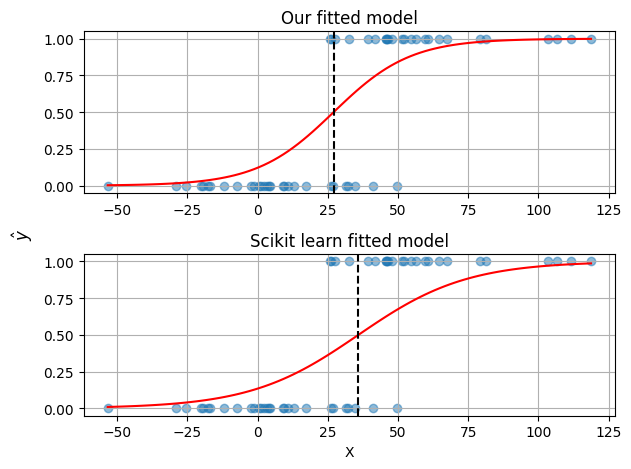

In [29]:
fig, ax = plt.subplots(2,1)
plot_logistic(X, y, lm_scratch.w, lm_scratch.b, ax=ax[0])
# plot sample points colored by their predicted class
y_hat = (lm_scratch.predict(X)>=0.5).ravel()
ax[0].axvline(-lm_scratch.b/lm_scratch.w, color='k', linestyle='--')
ax[0].set_title('Our fitted model')
plot_logistic(X, y, w_sk, b_sk, ax=ax[1])
ax[1].axvline(-b_sk/w_sk, color='k', linestyle='--')
ax[1].set_title('Scikit learn fitted model')
ax[1].set_xlabel('X')
fig.supylabel('$\hat{y}$')
fig.tight_layout()

The parameters are pretty close, and the performance is comparable. Since we have access to the history of values for the `b` and `w` parameters during the iterations of gradient descent, we can see how they evolve during the fitting process.

/var/folders/xr/cvz2q4cs7mn5n78kvjyvkb_00000gn/T/ipykernel_50874/2274753704.py:2: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  ax.plot(lm_scratch.b_hist, lm_scratch.w_hist, 'k', label='GD path', color='white')


Text(0.5, 1.0, 'Loss landscape with gradient descent path')

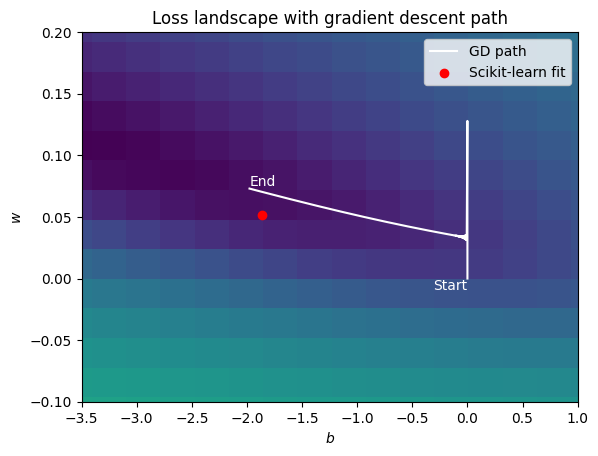

In [30]:
ax,_ = plot_logistic_loss_landscape(sel_data=np.arange(0, X.size))
ax.plot(lm_scratch.b_hist, lm_scratch.w_hist, 'k', label='GD path', color='white')
ax.text(lm_scratch.b_hist[0], lm_scratch.w_hist[0], 'Start', ha='right', va='top', color='white')
ax.text(lm_scratch.b_hist[-1], lm_scratch.w_hist[-1], 'End', ha='left', va='bottom', color='white')
ax.scatter(b_sk, w_sk, color='r', label='Scikit-learn fit')
ax.legend()
ax.set_xlim([-3.5, 1])
ax.set_ylim([-0.1, 0.2])
ax.grid(False)
ax.set_title('Loss landscape with gradient descent path')

Looking at the path taken, we can see there is some initial fluctuation before it starts to descend along the path towards the minimum. It does not reach it, but neither did the output of scikit-learn! There are ways to improve the gradient process by modifying the learning rate based on the decrease in the loss, or integrating information from the trajectories past into how we calculate its present one.

Another modification to the gradient descent algorithm is to make it operate on a different random subset of the data for each iteration. This is known as *stochastic gradient descent*. Since our loss function is the mean loss across all samples, it may be that only a small subset of the samples are required to get a good estimate of the mean. This can make the algorithm more computationally efficient, since fewer predictions must be computed on each iteration. It can also lead to better generalization, since a few outlier observations will not skew each update of our model parameters.

To do this, we will add a new parameter to our fitting process, *batch size*. This specifies how many samples are to be used for each step of gradient descent.

In [31]:
class LogisticModelSGD(LogisticModel):
    def fit(self, x, y, lr=0.1, tol=0.01, max_iter=100, batch_size=1):
        # Parameters
        # ----------
        # x : array-like
        #     Input data
        # y : array-like
        #     Target values
        # lr : float, optional
        #     Learning rate
        # tol : float, optional
        #     Tolerance for stopping criterion
        # max_iter : int, optional
        #     Maximum number of iterations
        # batch_size : int, optional
        #     Number of samples to use for each step of gradient descent

        # Returns
        # -------
        # self : LogisticModelSGD
        #     The fitted model

        # initialize the history of w and b values
        self.w_hist = [self.w]
        self.b_hist = [self.b]

        # ensure y and x are formatted as column vectors
        y = y.reshape(-1,1)
        x = x.reshape(-1,1)

        # run gradient descent until the stopping criterion is met
        # or until we reach the maximum number of iterations
        for i in range(max_iter):
            # randomly select batch_size samples
            sel_data = np.random.choice(np.arange(0, x.size), size=batch_size, replace=False)

            # predict y values using the current w and b values
            y_hat = self._logistic(x[sel_data])
            self.loss_hist.append(self._cross_entropy_loss(y[sel_data], y_hat))

            self.w -= lr*self._derivative_w(x[sel_data], y[sel_data], y_hat)
            self.b -= lr*self._derivative_b(y[sel_data], y_hat)
            
            # add the new w and b values to the history
            self.w_hist.append(self.w)
            self.b_hist.append(self.b)

            # check if the stopping criterion is met
            # if so, break out of the loop
            if (i>0) and (np.abs(self.loss_hist[-1] - self.loss_hist[-2]) < tol):
                break


Inheriting from our `LogisticModel` class, we modify the `fit` function to include a `batch_size` parameter. This sets the number of samples used. How does this version perform?

Our fitted model parameters: w=0.07, b=-2.02
Scikit learn model parameters: w=0.05, b=-1.86
Our fitted model score: 85.19%


/var/folders/xr/cvz2q4cs7mn5n78kvjyvkb_00000gn/T/ipykernel_50874/684223024.py:8: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  ax.plot(lm_sgd.b_hist, lm_sgd.w_hist, 'k', label='GD path', color='white')


Text(0.5, 1.0, 'Loss landscape with gradient descent path')

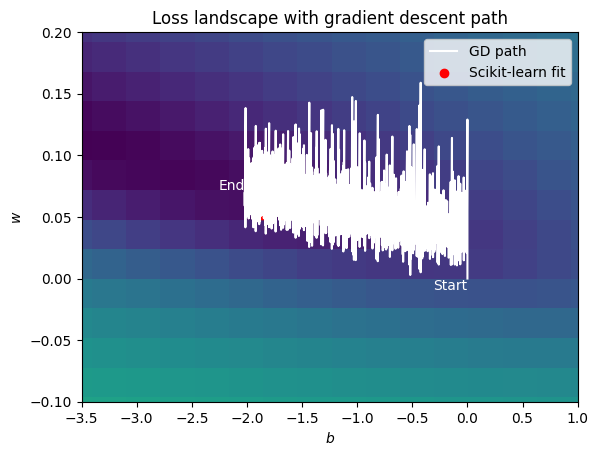

In [32]:
lm_sgd = LogisticModelSGD()
lm_sgd.fit(X, y, lr=0.01, tol=0.000001, max_iter=2000, batch_size=30)
print('Our fitted model parameters: w={:.2f}, b={:.2f}'.format(lm_sgd.w, lm_sgd.b))
print('Scikit learn model parameters: w={:.2f}, b={:.2f}'.format(w_sk, b_sk))
print('Our fitted model score: {:.2f}%'.format(lm_sgd.score(X, y)*100))

ax,_ = plot_logistic_loss_landscape(sel_data=np.arange(0, X.size))
ax.plot(lm_sgd.b_hist, lm_sgd.w_hist, 'k', label='GD path', color='white')
ax.text(lm_sgd.b_hist[0], lm_sgd.w_hist[0], 'Start', ha='right', va='top', color='white')
ax.text(lm_sgd.b_hist[-1], lm_sgd.w_hist[-1], 'End', ha='right', va='bottom', color='white')
ax.scatter(b_sk, w_sk, color='r', label='Scikit-learn fit')
ax.legend()
ax.set_xlim([-3.5, 1])
ax.set_ylim([-0.1, 0.2])
ax.grid(False)
ax.set_title('Loss landscape with gradient descent path')

Using stochastic gradient descent yields comparable performance, and with fewer samples processed per iteration. However, the path it takes is far less smooth, zigging and zagging towards the minimum. To minimize this jitter a momentum term is often included. There are several different ways to implement momentum, and we will use the one that treats it as a moving average of the gradient over successive iterations. The gamma parameter controls the mixture of the currently calculated gradient and the running average of its past values. For `w` (it will be the same for `b`), we can write this as:

$$ \begin{align}
    dw &= \gamma dw + (1-\gamma)\frac{\partial{L}}{\partial{w}} \notag \\
    w &= w - \eta dw \notag \\
    \end{align}
$$

Here the $\gamma$ (gamma) parameter sets how much the past change in value of the model parameter contributes to its current update. $\gamma$ ranges from 0 to 1, with 0 making the update equivalent to normal gradient descent, and values close to 1 making the update almost wholly dependent on its previous value. Note that $\gamma=1$ would result in no descent since the gradient would never update. A physical intuitiion for $\gamma$ is that increasing it makes the path taken by gradient descent more 'sticky', less likely to be swayed from batch to batch.

In [33]:
# logistic regression model with momentum added to the gradient descent step
class LogisticModelSGD_Mom(LogisticModel):
    def fit(self, x, y, lr=0.1, tol=0.01, max_iter=100, batch_size=1, gamma=0.9):
        # Parameters
        # ----------
        # x : array-like
        #     Input data
        # y : array-like
        #     Target values
        # lr : float, optional
        #     Learning rate
        # tol : float, optional
        #     Tolerance for stopping criterion
        # max_iter : int, optional
        #     Maximum number of iterations
        # batch_size : int, optional
        #     Number of samples to use for each step of gradient descent
        # gamma : float, optional
        #     Momentum parameter

        # Returns
        # -------
        # self : LogisticModelSGD
        #     The fitted model

        # initialize the history of w and b values
        self.w_hist = [self.w]
        self.b_hist = [self.b]

        # ensure y and x are formatted as column vectors
        y = y.reshape(-1,1)
        x = x.reshape(-1,1)

        # initialize the momentum
        mw = 0
        mb = 0
        
        # run gradient descent until the stopping criterion is met
        # or until we reach the maximum number of iterations
        for i in range(max_iter):
            # randomly select batch_size samples
            sel_data = np.random.choice(np.arange(0, x.size), size=batch_size, replace=False)

            # predict y values using the current w and b values
            y_hat = self._logistic(x[sel_data])
            self.loss_hist.append(self._cross_entropy_loss(y[sel_data], y_hat))

            # calculate the gradient
            dw = self._derivative_w(x[sel_data], y[sel_data], y_hat)
            db = self._derivative_b(y[sel_data], y_hat)

            # update the momentum
            mw = gamma*mw + (1-gamma)*dw
            mb = gamma*mb + (1-gamma)*db

            # update the weights and bias
            self.w -= lr*mw
            self.b -= lr*mb
            
            # add the new w and b values to the history
            self.w_hist.append(self.w)
            self.b_hist.append(self.b)

            # check if the stopping criterion is met
            # if so, break out of the loop
            if (i>0) and (np.abs(self.loss_hist[-1] - self.loss_hist[-2]) < tol):
                break

Now let's run it and see how it performs!

Our fitted model parameters: w=0.07, b=-2.49
Scikit learn model parameters: w=0.05, b=-1.86
Our fitted model score: 87.04%


/var/folders/xr/cvz2q4cs7mn5n78kvjyvkb_00000gn/T/ipykernel_50874/3430067328.py:8: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  ax.plot(lm_sgd.b_hist, lm_sgd.w_hist, 'k', label='GD path', color='white')


Text(0.5, 1.0, 'Loss landscape with gradient descent path')

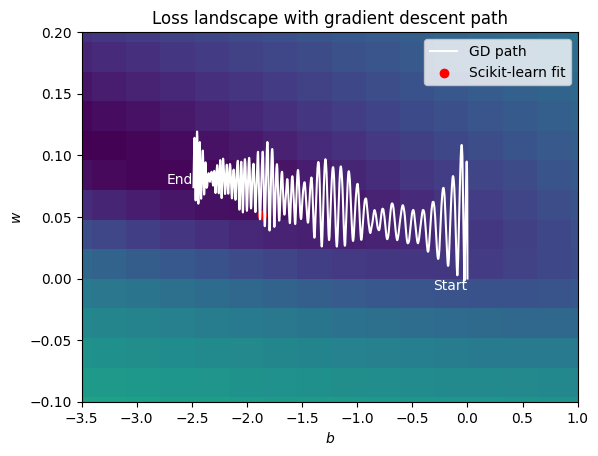

In [34]:
lm_sgd = LogisticModelSGD_Mom()
lm_sgd.fit(X, y, lr=0.015, tol=0.000001, max_iter=2000, batch_size=30, gamma=0.99)
print('Our fitted model parameters: w={:.2f}, b={:.2f}'.format(lm_sgd.w, lm_sgd.b))
print('Scikit learn model parameters: w={:.2f}, b={:.2f}'.format(w_sk, b_sk))
print('Our fitted model score: {:.2f}%'.format(lm_sgd.score(X, y)*100))

ax,_ = plot_logistic_loss_landscape(sel_data=np.arange(0, X.size))
ax.plot(lm_sgd.b_hist, lm_sgd.w_hist, 'k', label='GD path', color='white')
ax.text(lm_sgd.b_hist[0], lm_sgd.w_hist[0], 'Start', ha='right', va='top', color='white')
ax.text(lm_sgd.b_hist[-1], lm_sgd.w_hist[-1], 'End', ha='right', va='bottom', color='white')
ax.scatter(b_sk, w_sk, color='r', label='Scikit-learn fit')
ax.legend()
ax.set_xlim([-3.5, 1])
ax.set_ylim([-0.1, 0.2])
ax.grid(False)
ax.set_title('Loss landscape with gradient descent path')

Still a ragged path, but certainly smoother than when we did not include momentum. Note also that this is despite having also increased the learning rate term, which generally makes the gradient descent path less stable.

## Building the logistic regression model with PyTorch

Our scratch built logistic model has given us a good understanding of the basic underlying math and algorithms, but it is not how such models are often built. If you want to create a custom decoder, it better to build it from a package of general purpose functions. You could imagine that some functions would handle the chunking of the data, others the operations and transforms applied by the models, and another for the optimization. One such python package that offers all these features is PyTorch.

PyTorch is widely used for the construction of machine learning (especially deep neural network) models. It has a native data object, a `Tensor`, which is a multidimensional array. Also featured are a collection of standard linear algebra and mathematical operations that can operate on tensors. The parameters of these operations or values within the tensors can be updated with a variety of optimization functions featuring different forms of gradient descent.

Most importantly, as we progress in our use of logistic models to more complex neural decoding problems you may want to use PyTorch. It allows you to program your decoders at a higher level of abstraction (e.g., you don't have to write your own gradient descent algorithm), which saves time.

To start, let's create a `Dataset` object that will contain the neural measures and trial labels. `Dataset` is a class built in to PyTorch that gives it access to the data we want to train on. Crucially, it is useful when constructing batches of data for running stochastic gradient descent.

There are three methods we must specify when creating a custom `Dataset` class. The `__init__` method is used to initialize the object. Its input parameters allow us to specify the paths or variables where predictors and labels are stored, and transforms we want to apply to those before passing on to the decoder. Seperate transform functions can be applied to the predictors and labels. 

We then specify the `__len__` function, whose role is to simply to indicate how many samples are part of the dataset.

Finally, we create a `__getitem__` method, which gives access to samples in the dataset. An index parameter is passed to this method that specifies the sample to return, and it in turn transforms and returns the corresponding predictor and labels.

In [35]:
class ERPData(Dataset):
    def __init__(self, erp_pred, trial_lbl, transform=None, target_transform=None):
        # Parameters
        # ----------
        # erp_pred : array-like
        #     ERP data
        # trial_lbl : array-like
        #     Trial labels
        # transform : callable, optional
        #     Optional transform to be applied to the ERP data
        # target_transform : callable, optional
        #     Optional transform to be applied to the trial labels

        self.erp_pred = erp_pred
        self.trial_lbl = trial_lbl
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        # Returns
        # -------
        # len : int
        #     Number of samples in the dataset

        return len(self.trial_lbl)
    
    def __getitem__(self, idx):
        # Parameters
        # ----------
        # idx : int
        #     Index of the sample to return

        # Returns
        # -------
        # erp : array-like
        #     ERP data for the selected sample
        # lbl : array-like
        #     Trial label for the selected sample
        
        erp = self.erp_pred[idx] # get the ERP data for the selected sample
        lbl = self.trial_lbl[idx] # get the trial label for the selected sample
        if self.transform is not None: # apply the transform to the ERP data
            erp = self.transform(erp)
        if self.target_transform is not None: # apply the transform to the trial label
            lbl = self.target_transform(lbl)
        return erp, lbl

Let's give it a try!

In [36]:
erp_ds = ERPData(X, y)

# print the number of samples in the dataset
print('Number of samples in the dataset: {}'.format(len(erp_ds)))

# print the first sample in the dataset
erp, lbl = erp_ds[0]
print('ERP data for the first sample: {}, {}'.format(erp, lbl))

# print just the erp for the first sample in the dataset
erp = erp_ds[0][0]
print('ERP data for the first sample: {}'.format(erp))

# print just the label for the first sample in the dataset
lbl = erp_ds[0][1]
print('Label for the first sample: {}'.format(lbl))

# print the first 10 samples in the dataset
erp, lbl = erp_ds[:10]
print('ERP data for the first 10 samples:')
for samp in zip(erp, lbl):
    print('{}, {}'.format(samp[0], samp[1]))

# print the last sample in the dataset
erp, lbl = erp_ds[-1]
print('ERP data for the last sample: {}, {}'.format(erp,lbl))

Number of samples in the dataset: 54
ERP data for the first sample: [47.8682191], True
ERP data for the first sample: [47.8682191]
Label for the first sample: True
ERP data for the first 10 samples:
[47.8682191], True
[79.21943476], True
[59.77661572], True
[67.42808345], True
[106.59886022], True
[45.76555801], True
[103.45205398], True
[56.59460022], True
[60.77195205], True
[111.57862896], True
ERP data for the last sample: [-53.37683445], False


Once we have created a `Dataset` object for our ERP data, we can pass it to the PyTorch `DataLoader` object. It partitions the data into batches that can be used for stochastic gradient descent later in the training.

In [37]:
# Create a DataLoader object
erp_dl = DataLoader(erp_ds, batch_size=5, shuffle=True)

# Load a batch of data
erps, lbls = next(iter(erp_dl))

# print the dimensions of the erps and label tensors
print('ERP data dimensions: {}'.format(erps.shape))
print('Label dimensions: {}'.format(lbls.shape))

print('ERP data for the first batch:')
for samp in zip(erps, lbls):
    print('{}, {}'.format(samp[0], samp[1]))
    

ERP data dimensions: torch.Size([5, 1])
Label dimensions: torch.Size([5])
ERP data for the first batch:
tensor([60.7720], dtype=torch.float64), True
tensor([64.4758], dtype=torch.float64), True
tensor([56.5946], dtype=torch.float64), True
tensor([103.4521], dtype=torch.float64), True
tensor([3.8980], dtype=torch.float64), False


Here we created a `DataLoader` object and customized its behavior. The `batch_size` argument specified how many samples went into each batch, in this case 5. Using the `shuffle` argument set it up so that samples were drawn at random, instead of in the order they are natively stored. This is needed to ensure our samples are randomly drawn for stochastic gradient descent.

When samples are returned by the `DataLoader`, they come as the `tensor` data type. A tensor is a multidimensional array, similar to the `array` data type in Numpy. Compared with python data types for storing numeric data, such as lists, tensors offer several advantages. These are largely on the low-level backend side. They take up less memory by storing numbers with *C* data types instead of as python objects (a python number is an object with lots of metadata associated with it that fills up memory). They are faster because they are stored in memory as contiguous blocks, which can be read and written to faster. And equally important, they can be stored or processed on graphical processing units (GPUs) that dramatically speed up the computations for optimization and prediction.

The tensor returned by the `DataLoader` has a dimension of 5x1. The first dimension is the number of samples in the batch, and each subsequent dimension corresponds to the dimensionality of our features. In the case of the ERP fit, that is only a single number, so the dimension is 1. However, hypothetically, if we were training with images, it might have the size 5x3x256x256, where the dimensions correspond to *sample* x *channel* x *height* x *width*.

The `DataLoader` can be used in a for loop to return multiple batches of samples. To do this, use the `enumerate` function built in to Python that repeatedly calls an objects `__getitem__` method until the number of samples returned equals the total number of samples in the `Dataset` referenced by `DataLoader`.

In [38]:
for i, (erp, lbl) in enumerate(erp_dl):
    print('Batch {}: erp shape = {}, lbl shape = {}'.format(i, erp.shape, lbl.shape))

Batch 0: erp shape = torch.Size([5, 1]), lbl shape = torch.Size([5])
Batch 1: erp shape = torch.Size([5, 1]), lbl shape = torch.Size([5])
Batch 2: erp shape = torch.Size([5, 1]), lbl shape = torch.Size([5])
Batch 3: erp shape = torch.Size([5, 1]), lbl shape = torch.Size([5])
Batch 4: erp shape = torch.Size([5, 1]), lbl shape = torch.Size([5])
Batch 5: erp shape = torch.Size([5, 1]), lbl shape = torch.Size([5])
Batch 6: erp shape = torch.Size([5, 1]), lbl shape = torch.Size([5])
Batch 7: erp shape = torch.Size([5, 1]), lbl shape = torch.Size([5])
Batch 8: erp shape = torch.Size([5, 1]), lbl shape = torch.Size([5])
Batch 9: erp shape = torch.Size([5, 1]), lbl shape = torch.Size([5])
Batch 10: erp shape = torch.Size([4, 1]), lbl shape = torch.Size([4])


We have a total of 54 samples in the dataset `erp_ds`, and you can see that a total of 54 samples are returned when we call `erp_dl` using enumerate in a for loop. We specified that the `DataLoader` object should return a batch with 5 samples, and 10 the returned batches had 5 samples. The last batch only has 4 samples because that was the remainder (54 total samples - 5 samples per batch * 10 batches).

Now that we have our data, we need to setup the logistic function. Recall that it has the form:

$$ p(Event|x)=\frac{1}{(1+e^{-(b+wx)})} $$

We can break it down into two parts. The first is a linear equation, $b+wx$, which scales (with $w$) and shifts ($b$) our ERP value. This rescaled ERP value is then passed to the logistic function, $\frac{1}{1+e^{-z}}$, converts it to a probability between 0 and 1. Note that $z=b+wx$. 

Pytorch offers objects to handle both of these functions. The linear equation can be found in `torch.nn.linear`. The 'nn' stands for *neural network*. Many neural networks make use of a linear transform layer, so that is implemented as part of that module. This object implements a linear equation, essentially a matrix that can be multiplied by an incoming vector. It has the form:

$$ z_j = b_j+\sum_{i=0}^{n}w_{i,j}x_i $$
where n is the number of inputs, $x_i$, each is multiplied by a distinct weight, $w_{i,j}$. These are summed together and a bias, $b_j$, is added to give an output $z_j$. Since our logistic model has only one input and output, the equation simplifies to:

$$ z = b + wx $$
To implement this using PyTorch we code:

In [39]:
# create a linear transformation with 1 input, 1 output, and a bias
lin_trans = torch.nn.Linear(1, 1, bias=True)

The first argument of `Linear` is the number of inputs, while the second is the number of outputs. Settings the `bias` argument to `True` adds the bias term, $b$. When the `Linear` layer is initialized, its weight ($w$) and bias are given random values. You can directly inspect them as properties of the `Linear` object you created.

In [40]:
# print the weight and bias values
print('Linear layer weight value is: {}'.format(lin_trans.weight))
print('Linear layer bias value is: {}'.format(lin_trans.bias))

Linear layer weight value is: Parameter containing:
tensor([[0.1157]], requires_grad=True)
Linear layer bias value is: Parameter containing:
tensor([0.9718], requires_grad=True)


In addition, you can pass a value to the `Linear` object as if it were a function, with it returning the transformed value. However, make sure the value you pass to it is a tensor, since that is the datatype it expects.

In [41]:
t0 = torch.tensor([0.0]) # create a tensor with a single value of 0
t1 = torch.tensor([1.0]) # create a tensor with a single value of 1

print('Value of lin_trans at 0: {}'.format(lin_trans(t0)))
print('Value of lin_trans at 1: {}'.format(lin_trans(t1)))


Value of lin_trans at 0: tensor([0.9718], grad_fn=<ViewBackward0>)
Value of lin_trans at 1: tensor([1.0875], grad_fn=<ViewBackward0>)


If we want to plot the output of `lin_trans`, things get a little bit more complicated. First we have to create a tensor of `x` values.

In [42]:
# create numpy array with 100 values between -10 and 10
# cast the array to float32 data type for PyTorch compatibility
x = np.linspace(-10, 10, 100).astype(np.float32)
print('Data type and shape of x: {}, {}'.format(x.dtype, x.shape))

# convert numpy array to a PyTorch tensor
x_t = torch.tensor(x).reshape(-1,1)
print('Data type and shape of x_t: {}, {}'.format(x_t.dtype, x_t.shape))

Data type and shape of x: float32, (100,)
Data type and shape of x_t: torch.float32, torch.Size([100, 1])


A few things to note here. We assign the numeric data type to be `np.float32`, which stands for floating point 32-bit. This is the default numeric data type used by tensors in Pytorch. If we don't assign that, we may get an error due to our bias and weights being of incompatible data types from our inputs. We also have to convert the numpy array `x` to a tensor, which is done using the `torch.tensor` function. In addition, it needs to be reshaped to ensure that the first dimension corrsponds to the samples (100 in this case), and the second dimension to the number of features (1).

Now that we have a properly formatted input `x_t`, we can pass it to `lin_trans`.

In [43]:
y_t = lin_trans(x_t)
print('Data type and shape of y: {}, {}'.format(y_t.dtype, y_t.shape))
print('y: \n{}'.format(y_t))

Data type and shape of y: torch.float32, torch.Size([100, 1])
y: 
tensor([[-1.8480e-01],
        [-1.6144e-01],
        [-1.3807e-01],
        [-1.1471e-01],
        [-9.1339e-02],
        [-6.7973e-02],
        [-4.4607e-02],
        [-2.1241e-02],
        [ 2.1247e-03],
        [ 2.5491e-02],
        [ 4.8857e-02],
        [ 7.2223e-02],
        [ 9.5589e-02],
        [ 1.1895e-01],
        [ 1.4232e-01],
        [ 1.6569e-01],
        [ 1.8905e-01],
        [ 2.1242e-01],
        [ 2.3578e-01],
        [ 2.5915e-01],
        [ 2.8252e-01],
        [ 3.0588e-01],
        [ 3.2925e-01],
        [ 3.5261e-01],
        [ 3.7598e-01],
        [ 3.9935e-01],
        [ 4.2271e-01],
        [ 4.4608e-01],
        [ 4.6944e-01],
        [ 4.9281e-01],
        [ 5.1618e-01],
        [ 5.3954e-01],
        [ 5.6291e-01],
        [ 5.8627e-01],
        [ 6.0964e-01],
        [ 6.3301e-01],
        [ 6.5637e-01],
        [ 6.7974e-01],
        [ 7.0310e-01],
        [ 7.2647e-01],
        [ 7.49

`lin_trans` returns another tensor, which cannot be directly passed to matplotlib. The tensor object has a gradient associated with it, `grad_fn=<AddmmBackward0>`, that must be removed. In addition, we could convert the numeric array inside the tensor object into a numpy array (use `.numpy()` to do that), but matplotlib will accept a tensor without the gradient as a valid input, so we can forgo that.

In [44]:
print('Here is the first five values of tensor y_t with the gradient removed: \n{}'.format(y_t[:5].detach()))

# remove the gradient and convert tensor to numpy array
y_dt = y_t.detach()
print('Data type and shape of y_dt: {}, {}'.format(type(y_dt), y_dt.shape))

Here is the first five values of tensor y_t with the gradient removed: 
tensor([[-0.1848],
        [-0.1614],
        [-0.1381],
        [-0.1147],
        [-0.0913]])
Data type and shape of y_dt: <class 'torch.Tensor'>, torch.Size([100, 1])


Now we are ready to plot!

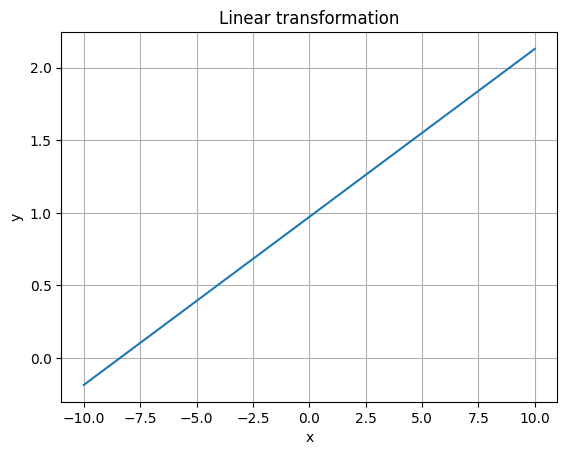

In [45]:
# plot the linear transformation
fig, ax = plt.subplots()
ax.plot(x_t, y_dt)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('Linear transformation')
ax.grid()

Now that we have implemented the linear function $b+wx$, we have to create the logistic function, $\frac{1}{1+e^{-z}}$. PyTorch has this function built in under the name `sigmoid`, which is just another name for the logistic function.

In [46]:
log_trans = torch.nn.Sigmoid()

We can plot the sigmoid function to make sure it has the same profile as the logistic function we have been working with.

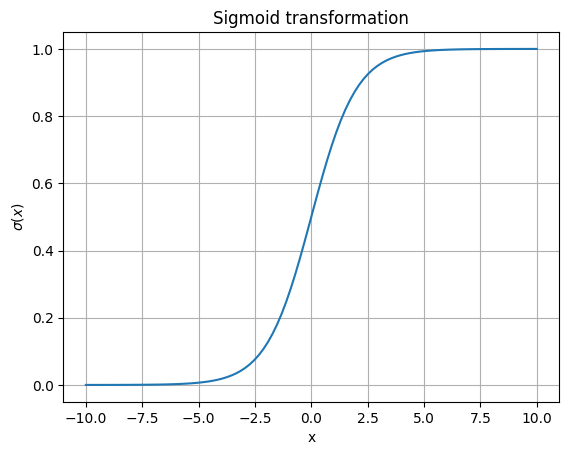

In [47]:
# plot the sigmoid transformation
fig, ax = plt.subplots()
x_t = torch.tensor(np.linspace(-10, 10, 100).astype(np.float32)).reshape(-1,1)
ax.plot(x_t, log_trans(x_t).detach())
ax.set_xlabel('x')
ax.set_ylabel(r'$\sigma(x)$')
ax.set_title('Sigmoid transformation')
ax.grid()


As with the linear transform, we had to format our Numpy array into a tensor that could be passed to the `Sigmoid` function, and had to then remove the gradient from the tensor returned by `Sigmoid` to plot it with matplotlib.

Now we need to chain the linear and sigmoid steps together, to create the logistic model. Pytorch provides the `nn.Sequential` object for doing this. With it, you pass in order the transforms and functions you want to chain together, and it returns a single object that encapsulates that sequence.

In [48]:
log_mdl = torch.nn.Sequential(
    lin_trans,
    log_trans
)

# print the model
print(log_mdl)

# print the model parameters
print('Model parameters:\n{}'.format(dict(log_mdl.named_parameters())))

Sequential(
  (0): Linear(in_features=1, out_features=1, bias=True)
  (1): Sigmoid()
)
Model parameters:
{'0.weight': Parameter containing:
tensor([[0.1157]], requires_grad=True), '0.bias': Parameter containing:
tensor([0.9718], requires_grad=True)}


We can pass values to the `Sequential` object just like we did to the `Linear` and `Sigmoid` functions. For instance, if we wanted to plot it we would:

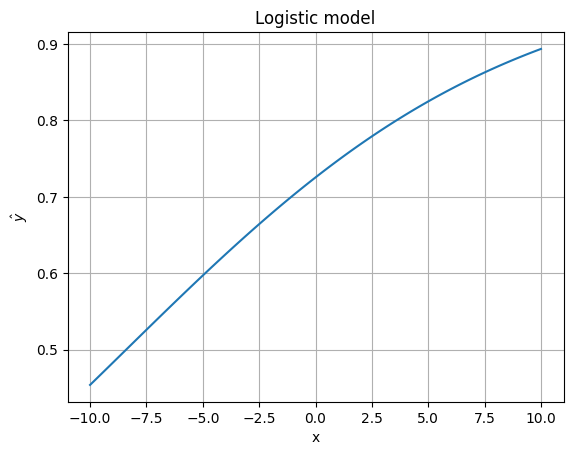

In [49]:
y_t = log_mdl(x_t)
fig, ax = plt.subplots()
ax.plot(x_t, y_t.detach())
ax.set_xlabel('x')
ax.set_ylabel(r'$\hat{y}$')
ax.set_title('Logistic model')
ax.grid()


Looks like a logistic model. Since the weights and bias were set randomly, this model will not necessarily perform well on our data set. We have to optimize those model parameters using the cross-entropy loss and gradient descent. PyTorch features functions and objects for handling both of those.

PyTorch has a suite of loss functions to choose from. You may be tempted to use its `CrossEntropyLoss` function, since that is what we used for our scratch built code above. However, in PyTorch the `CrossEntropyLoss` function is designed for measuring loss when multiple categories of events are being decoded (more than 1), and so it would ot be appropriate for our binary case, which is just detecting whether or not a cue was present. Instead, we will use the `BCELoss` function, which stands for *binary cross entropy loss*. This is used when only a single outcome is being predicted, and if you refer to the PyTorch documentation for it (https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html), you will see that it is the same equation for cross-entropy loss used above.

In [50]:
loss_fn = torch.nn.BCELoss()

We also have to create a function optimize the parameters based on the loss. To do this in our scratch built version, we hand coded stochastic gradient descent with momentum. PyTorch provides this built-in with their `optimizer` object. It implements a variety of gradient descent algorithms, including the one we used. To invoke it:

In [51]:
optimizer = torch.optim.SGD(log_mdl.parameters(), lr=0.001, momentum=0.9)

To use it, we pass the parameters we want to update, and optionally the learning rate and momentum. An optimizer object features a `step` method, which updates the parameters. Before calling it, we also have to clear any previous gradients that had been calculated, or else they will keep accumulating and throw off the gradient descent process.

Now that we have the loss function and optimizer, run gradient descent. To do this, we use `log_mdl` to predict the labels based on the features and then pass them and the true labels to the loss function.

In [52]:
# get a batch of data with the dataloader
erps, lbls = next(iter(erp_dl))

# predict the labels for the batch
y_hat = log_mdl(erps.float())

# calculate the loss
loss = loss_fn(y_hat, lbls.float().reshape(-1,1))

print('Loss: {}'.format(loss))

Loss: 0.10505354404449463


Once the loss is calculated, we can use it to update the parameters of our logistic model. In our scratch built version, we had dervied the gradient of loss with respect to each parameter ($\frac{\partial{L}}{\partial{w}}$ and $\frac{\partial{L}}{\partial{b}}$), which allowed us to explicitly calculate these changes. This is alright for simple decoders, like the logistic model, but becomes prohibitive with more complex ones. Since PyTorch is designed to handle such complex models, it can automatically calculate the gradient for each parameter, known as *autograd*. The details of this, or the deeper workings of PyTorch as a computation graph engine, are beyond the scope of this course, but for a good overview check out the official PyTorch documentation (https://pytorch.org/blog/overview-of-pytorch-autograd-engine/). 

What you should know is that each function and tensor can have a gradient associated with it. Indeed, to plot the tensors above we had to remove this gradient using the `.detach()` method. As you chain tensors and functions together, like we do with `nn.Sequential`, these gradients can be used to calculate the derivative of each parameter with respect to the loss.  which propagates backward for each model parameter. To see the parameters for our logistic model, you just need to call its `.parameters()` method.

In [53]:
# print the parameters of the logistic model
list(log_mdl.parameters())

[Parameter containing:
 tensor([[0.1157]], requires_grad=True),
 Parameter containing:
 tensor([0.9718], requires_grad=True)]

Note that the tensor for each parameter has a `requires_grad=True`, so they are subject to updating. You can also inspect the value of their gradients.

In [54]:
print("The gradient associated with w: {}".format(log_mdl[0].weight.grad))
print("The gradient associated with b: {}".format(log_mdl[0].bias.grad))

The gradient associated with w: None
The gradient associated with b: None


They show up as `None` because no loss has been calculated yet and propagated backward towards parameters. To do that, we use the `backward` method for the loss tensor. This propagates the loss value back through the sigmoid and linear function towards the weight and bias parameters.

In [55]:
optimizer.zero_grad()
loss.backward()

print("The gradient associated with w: {}".format(log_mdl[0].weight.grad))
print("The gradient associated with b: {}".format(log_mdl[0].bias.grad))

The gradient associated with w: tensor([[-1.7368]])
The gradient associated with b: tensor([0.0919])


Now that we have the gradient of the loss with respect to weight and bias, we can update those parameters. 

In [56]:
# print previous values of the parameters
print("Model parameters before updating:\n{}".format(list(log_mdl.parameters())))

# update parameters using the optimizer
optimizer.step()

# print the updated parameters
print("Model parameters after updating:\n{}".format(list(log_mdl.parameters())))


Model parameters before updating:
[Parameter containing:
tensor([[0.1157]], requires_grad=True), Parameter containing:
tensor([0.9718], requires_grad=True)]
Model parameters after updating:
[Parameter containing:
tensor([[0.1174]], requires_grad=True), Parameter containing:
tensor([0.9717], requires_grad=True)]


Notice that the model parameters change after running `optimizer.step`. To fit the model, we want to do this repeatedly across many iterations. We can use a for loop for this purpose, and call up different random batches of samples using the `DataLoader` object.

To start, let's reinitialize our logistic model, loss function, and optimizer.

In [57]:
# create a linear transformation with 1 input, 1 output, and a bias
lin_trans = torch.nn.Linear(1, 1, bias=True)
log_trans = torch.nn.Sigmoid()
log_mdl = torch.nn.Sequential(
    lin_trans,
    log_trans
)

# initialize binary cross-entropy loss function and SGD optimizer
loss_fn = torch.nn.BCELoss()
optimizer = torch.optim.SGD(log_mdl.parameters(), lr=0.001, momentum=0.9)

Now we used stochastic gradient descent to optimize our logistic model across 200 epochs of our data. Each epoch is a run through all the batches in our dataset.

Epoch 0: loss = 0.1537, accuracy = 68.52%
Epoch 10: loss = 0.9024, accuracy = 87.04%
Epoch 20: loss = 0.4368, accuracy = 79.63%
Epoch 30: loss = 0.0902, accuracy = 87.04%
Epoch 40: loss = 0.3606, accuracy = 85.19%
Epoch 50: loss = 0.1944, accuracy = 85.19%
Epoch 60: loss = 0.5057, accuracy = 85.19%
Epoch 70: loss = 0.0802, accuracy = 85.19%
Epoch 80: loss = 0.0927, accuracy = 85.19%
Epoch 90: loss = 0.3489, accuracy = 87.04%
Epoch 100: loss = 0.1246, accuracy = 88.89%
Epoch 110: loss = 0.3770, accuracy = 87.04%
Epoch 120: loss = 0.1375, accuracy = 88.89%
Epoch 130: loss = 0.1983, accuracy = 87.04%
Epoch 140: loss = 0.1383, accuracy = 87.04%
Epoch 150: loss = 0.0797, accuracy = 87.04%
Epoch 160: loss = 0.6848, accuracy = 87.04%
Epoch 170: loss = 0.3135, accuracy = 85.19%
Epoch 180: loss = 0.1014, accuracy = 87.04%
Epoch 190: loss = 0.0356, accuracy = 87.04%


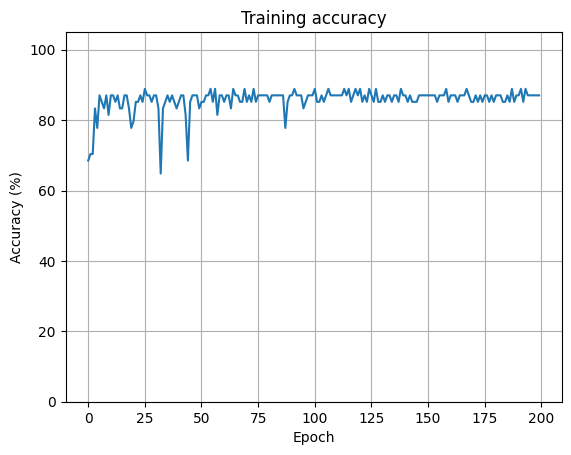

In [58]:
acc = []
for i in range(200):
    y_pred = log_mdl(torch.tensor(X.astype(np.float32))).detach().numpy()>0.5
    acc.append(np.mean(y_pred.ravel() == y.ravel())*100)
    for erp, lbl in erp_dl:
        y_hat = log_mdl(erp.float())
        loss = loss_fn(y_hat, lbl.float().reshape(-1,1))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    if i%10 == 0:
        print('Epoch {}: loss = {:.4f}, accuracy = {:.2f}%'.format(i, loss, acc[-1]))

fig, ax = plt.subplots()
ax.plot(acc)
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy (%)')
ax.set_title('Training accuracy')
ax.set_ylim([0, 105])
ax.grid()


Performance at asymptote is comparable to what we got with Scikit learn and our scratch built code. How do the model parameters, $w$ and $b$, compare across the different fits?

In [59]:
w_pt = float(lin_trans.weight.detach())
b_pt = float(lin_trans.bias.detach())

print('Scikit learn model parameters: w={:.2f}, b={:.2f}'.format(w_sk, b_sk))
print('Scatch model parameters: w={:.2f}, b={:.2f}'.format(lm_scratch.w, lm_scratch.b))
print('PyTorch model parameters: w={:.2f}, b={:.2f}'.format(w_pt, b_pt))


Scikit learn model parameters: w=0.05, b=-1.86
Scatch model parameters: w=0.07, b=-1.98
PyTorch model parameters: w=0.07, b=-2.42


Since the decision threshold for decoding whether a trial had a cue presented depends on both $w$ and $b$, it should be easier to compare the fits by plotting the curves of their respective logistic models.

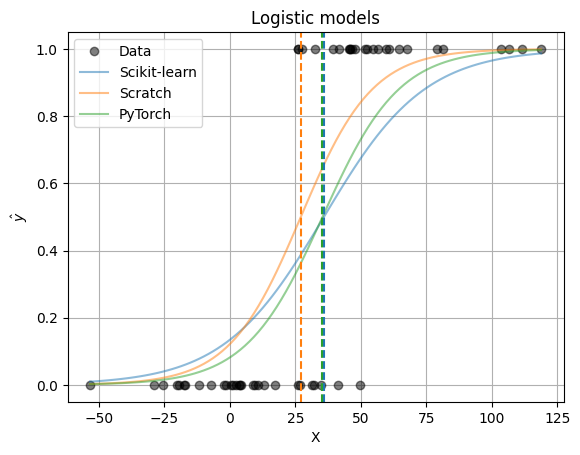

In [60]:
# create a plot with the three logistic fitted models overlaid
x_vals = np.linspace(np.min(X), np.max(X), 100)
fig, ax = plt.subplots()
ax.plot(X, y, 'o', label='Data', alpha=0.5, color='k')
ax.plot(x_vals, logistic(x_vals, w_sk, b_sk), color='tab:blue',label='Scikit-learn', alpha=0.5)
ax.plot(x_vals, logistic(x_vals, lm_scratch.w, lm_scratch.b), color='tab:orange',label='Scratch', alpha=0.5)
ax.plot(x_vals, logistic(x_vals, w_pt, b_pt), color='tab:green', label='PyTorch', alpha=0.5)
ax.axvline(-b_sk/w_sk, color='tab:blue', linestyle='--')
ax.axvline(-lm_scratch.b/lm_scratch.w, color='tab:orange', linestyle='--')
ax.axvline(-b_pt/w_pt, color='tab:green', linestyle='--')
ax.set_xlabel('X')
ax.set_ylabel(r'$\hat{y}$')
ax.set_title('Logistic models')
ax.legend()
ax.grid()


Remarkably, they have all converged on apprimately the same decision boundary. 